# LSTM Model for Sequential Classification

## Objective

The study aims to predict which customers are likely to purchase a targeted product based on their last ten transactions. Given the highly imbalanced nature of the data, various architectures, regularization, and class balancing techniques were explored to address the imbalance problem and improve the model's performance.

## To-Do List

+ Auto-encoder LSTM: treating the minority class as outliers, anomaly detection
+ CNN + LSTM
+ Graph embeddings
+ GNN

## Libraries and Dependencies

In this project, several key libraries are essential for efficient data processing, model building, and evaluation. keras-tuner is vital for hyperparameter tuning of Keras models, simplifying the optimization process through various search algorithms. rarfile handles RAR archive files, enabling seamless extraction of compressed datasets directly within Python. numpy supports large, multi-dimensional arrays and matrices, facilitating numerical computations crucial for data analysis.

Additionally, pandas aids in data manipulation and analysis, while sklearn provides tools for model training and evaluation. tensorflow.keras is used for building and training neural network models, integrating well with keras-tuner for optimized performance. Visualization tools like matplotlib and seaborn help create informative plots and charts, essential for interpreting data and results.

These libraries collectively ensure efficient data handling, robust model development, and insightful analysis, driving the project's success in sequential classification and data-driven decision-making.

In [ ]:
!pip install keras-tuner rarfile
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, matthews_corrcoef, balanced_accuracy_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import keras_tuner as kt
from keras_tuner import RandomSearch, HyperParameters, Objective
import json
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer
from google.colab import drive
import rarfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from kerastuner import RandomSearch, Objective
from sklearn.model_selection import KFold

<ipython-input-5-44e9862fe445>:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, Objective


## Functions & Classes

This section presumably contains custom functions and classes defined to support the project, such as data preprocessing, model building, training, and evaluation functions.

This function plots the class distribution of a binary classification dataset as a pie chart and saves the plot to a specified directory.

In [ ]:
def plot_class_distribution(y, set_name='Dataset', save_dir='images'):
    """
    Plots the class distribution of a binary classification dataset and saves the plot.

    Parameters:
    y (array-like): The binary labels of the dataset.
    set_name (str): The name of the dataset (for the plot title). Default is 'Dataset'.
    save_dir (str): The directory where the plot will be saved. Default is 'images'.

    """
    # Create the directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    num_pos = y.sum()
    num_neg = y.shape[0] - num_pos

    # Labels for the pie chart
    labels = ['Positive Sequences', 'Negative Sequences']

    # Data to plot
    sizes = [num_pos, num_neg]

    # Colors for each section
    colors = ['#ff9999', '#66b3ff']

    # Plotting the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Class Distribution of Sequences in {set_name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Save the plot
    file_path = os.path.join(save_dir, f'Class_Distribution_of_Sequences_in_{set_name}.png')
    plt.savefig(file_path)

    # Show the plot
    plt.show()


These three functions calculate common evaluation metrics for binary classification models: precision, recall, and F1 score.

In [ ]:
def precision_m(y_true, y_pred):
    """
    Computes the precision metric.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted labels.

    Returns:
    tensor: Precision metric.
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    """
    Computes the F1 score.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted labels.

    Returns:
    tensor: F1 score.
    """
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def mcc_m(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn) - (fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


This function plots the training accuracy and loss history of a model and saves the plots as images in the specified directory.

In [ ]:
def plot_and_save_training_history(history, model_name, save_dir='images'):
    """
    Plots the training history and saves the plots to the specified directory.

    Parameters:
    history: History object returned by model.fit().
    model_name (str): The name of the model (used for the plot file name).
    save_dir (str): The directory where the plot will be saved.

    """
    # Create the directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save plots
    accuracy_plot_path = os.path.join(save_dir, f'{model_name}_accuracy.png')
    loss_plot_path = os.path.join(save_dir, f'{model_name}_loss.png')
    plt.savefig(accuracy_plot_path)
    plt.savefig(loss_plot_path)

    # Show plots
    plt.show()

    print(f'Plots saved as {accuracy_plot_path} and {loss_plot_path}')


This function checks for duplicate sequences in the given numpy array.


In [ ]:
def check_duplicates(sequences):
    """
    Check for duplicate sequences in the given numpy array.

    Parameters
    ----------
    sequences : numpy.ndarray
        A 3D numpy array where the first dimension represents the number of sequences,
        and the remaining dimensions represent the transactions in each sequence.

    Returns
    -------
    int
        The number of duplicate sequences.
    numpy.ndarray
        Indices of the duplicate sequences in the original array.
    """
    # Reshape the array to a 2D shape where each sequence is a single row
    reshaped_sequences = sequences.reshape(sequences.shape[0], -1)

    # Find unique rows and their indices
    unique_sequences, indices = np.unique(reshaped_sequences, axis=0, return_index=True)

    # Find duplicates by comparing lengths
    num_duplicates = len(reshaped_sequences) - len(unique_sequences)

    # Find duplicate indices
    _, unique_indices, counts = np.unique(reshaped_sequences, axis=0, return_counts=True, return_index=True)
    duplicate_indices = np.where(counts > 1)[0]

    # Get the indices of duplicate sequences
    duplicate_sequence_indices = np.where(np.isin(reshaped_sequences, unique_sequences[duplicate_indices]))[0]

    return num_duplicates, duplicate_sequence_indices

In [ ]:
def plot_calibration_curve(y_test, y_pred_prob, n_bins=10):
    """
    Plots a calibration curve (reliability diagram) for the given true labels and predicted probabilities.

    Parameters:
    y_test (array-like): True labels
    y_pred_prob (array-like): Predicted probabilities
    n_bins (int): Number of bins to use in the calibration curve

    Returns:
    None
    """
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=n_bins)

    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()

In [ ]:
def print_all_metrics(y_true, y_pred, average='binary'):
    """
    Prints all the key metrics for model evaluation: accuracy, balanced accuracy, precision, recall, and F1 score.

    Parameters:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels
    average (str): Type of averaging performed on the data (default is 'binary').
                   Choose 'binary', 'micro', 'macro', or 'weighted' for multi-class classification.

    Returns:
    None
    """
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# Function to find the best threshold based on balanced F1 score
def find_balanced_threshold(y_true, y_pred_prob, thresholds):
    best_f1 = 0
    best_threshold = 0
    best_metrics = {}

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_metrics = {
                'Accuracy': accuracy_score(y_true, y_pred),
                'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'MCC': mcc
            }

    return best_threshold, best_metrics

In [ ]:
# Function to find the best threshold based on MCC score
def find_best_threshold_by_mcc(y_true, y_pred_prob, thresholds):
    best_mcc = -1  # Initialize with the lowest possible MCC
    best_threshold = 0
    best_metrics = {}

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)

        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
            best_metrics = {
                'Accuracy': accuracy_score(y_true, y_pred),
                'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'MCC': mcc
            }

    return best_threshold, best_metrics

In [ ]:
def plot_confusion_matrix(cm, model_name):
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix
    model_name (str): Name of the model (used for the plot title)

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# Unzip .rar files if they exist
def extract_rar(file_path, extract_dir):
    try:
        with rarfile.RarFile(file_path) as rf:
            rf.extractall(extract_dir)
            print(f"Extracted {file_path} successfully.")
    except Exception as e:
        print(f"Could not extract {file_path}: {e}")

In [ ]:
# Function to build and train the model
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])
    return model

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_classes)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, precision, recall, f1, mcc, balanced_acc

In [ ]:
# Function to remove duplicates
def remove_duplicates(sequences):
    reshaped_sequences = sequences.reshape(sequences.shape[0], -1)
    _, indices = np.unique(reshaped_sequences, axis=0, return_index=True)
    unique_sequences = sequences[indices]
    return unique_sequences

# Function to prepare data for training and evaluation
def prepare_data(neg_sequences, pos_sequences):
    X = np.concatenate((neg_sequences, pos_sequences), axis=0)
    y = np.concatenate((np.zeros(len(neg_sequences)), np.ones(len(pos_sequences))), axis=0)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Function to load the saved model
def load_saved_model(model_dir, model_name, custom_objects):
    model_path = os.path.join(model_dir, f"{model_name}.h5")
    model = load_model(model_path, custom_objects=custom_objects)
    model.summary()
    return model

In [ ]:
# Define the function to create the model
def create_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision_m, recall_m, f1_m])
    return model

In [ ]:
class KerasGridSearch(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=64, class_weight=None):
        self.epochs = epochs
        self.batch_size = batch_size
        self.class_weight = class_weight
        self.model = None

    def fit(self, X, y, validation_data=None, callbacks=None):
        self.model = create_model()
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                                      validation_data=validation_data, callbacks=callbacks,
                                      class_weight=self.class_weight)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        y_pred = self.predict(X)
        return recall_score(y, y_pred, pos_label=1)

## Data

+ The last 10 transactions customers made before purchasing (or not purchasing) the target product are collected.
+ One-hot-encoded versions of those sequential transactions are provided as positive and negative sequences.
+ The positive sequences are sequential transactions of the customers who eventually bought the target product, and the negative sequences are of those who did not.


To access files stored in Google Drive while using Google Colab, start by mounting Google Drive and loading the data. Set the working directory to "TEB" under "My Drive" and confirm the change by printing the current working directory. Define the paths to the data, models, and checkpoint directories, and attempt to read the '.npy' files. Note that the neg_sequences array contains 100,000 samples, and the pos_sequences array contains 11,979 samples. Each sample in both arrays consists of sequences of length 10 and 312 features.

In [ ]:
drive.mount('/content/drive')

# Get the current working directory
current_working_directory = os.getcwd()

# Print the current working directory
print(f"Current working directory: {current_working_directory}")

# Define the path to TEB under My Drive
teb_path = '/content/drive/My Drive/TEB'

# Change the current working directory to TEB
os.chdir(teb_path)

# Verify the change
current_working_directory = os.getcwd()
print(f"Current working directory: {current_working_directory}")

# Define directories
DATA_DIR = './data'
MODEL_DIR = './models'
CHECKPOINT_DIR = './checkpoints'
IMAGE_DIR = './images'

# Create the directories if they don't exist
for directory in [DATA_DIR, MODEL_DIR, CHECKPOINT_DIR, IMAGE_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define file names
neg_file = 'neg_sequences.npy'
pos_file = 'pos_sequences.npy'
neg_file_rar = 'neg_sequences.rar'
pos_file_rar = 'pos_sequences.rar'

# Full paths to the files
neg_file_path = os.path.join(DATA_DIR, neg_file)
pos_file_path = os.path.join(DATA_DIR, pos_file)
neg_file_rar_path = os.path.join(DATA_DIR, neg_file_rar)
pos_file_rar_path = os.path.join(DATA_DIR, pos_file_rar)

# Print the full paths for debugging
print(f"Negative sequences file path: {neg_file_path}")
print(f"Positive sequences file path: {pos_file_path}")

# List files in the data directory for debugging
print("Files in data directory:", os.listdir(DATA_DIR))

# Check and extract .rar files if necessary
if os.path.exists(neg_file_rar_path):
    extract_rar(neg_file_rar_path, DATA_DIR)

if os.path.exists(pos_file_rar_path):
    extract_rar(pos_file_rar_path, DATA_DIR)

# Read the .npy files
try:
    neg_sequences = np.load(neg_file_path)
    print("Negative sequences loaded successfully.")
except Exception as e:
    print(f"Could not read {neg_file}: {e}")

try:
    pos_sequences = np.load(pos_file_path)
    print("Positive sequences loaded successfully.")
except Exception as e:
    print(f"Could not read {pos_file}: {e}")

print(neg_sequences.shape)
print(pos_sequences.shape)

Mounted at /content/drive
Current working directory: /content
Current working directory: /content/drive/My Drive/TEB
Negative sequences file path: ./data/neg_sequences.npy
Positive sequences file path: ./data/pos_sequences.npy
Files in data directory: ['pos_sequences.rar', 'neg_sequences.rar', 'neg_sequences.npy', 'pos_sequences.npy']
Extracted ./data/neg_sequences.rar successfully.
Extracted ./data/pos_sequences.rar successfully.
Negative sequences loaded successfully.
Positive sequences loaded successfully.
(100000, 10, 312)
(11979, 10, 312)


Random sample from negaitive sequences is shown below:

In [ ]:
# Select a random index from the neg_sequences array
random_index = np.random.randint(0, len(neg_sequences))

# Get the sequence at the random index
sample_sequence = neg_sequences[random_index]
display(sample_sequence)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Duplicate Sequences: Should they stay or should they GO?

Duplicates can cause the model to overfit to certain sequences, thinking they are more common than they actually are. Without duplicates, the model learns from a more diverse set of examples and becomes more robust. On the other hand removing duplicates means losing some data, which might remove important context or patterns that could be beneficial for the model. If duplicates are a natural part of our dataset (e.g., many customers exhibit similar behavior), removing them might strip away realistic patterns that the model needs to learn.

To decide whether to keep them or not, we need to experiment with both scenarios—keeping duplicates and removing them—and observe the model performance.

In [ ]:
# Check duplicates in negative sequences
neg_num_duplicates, neg_duplicate_sequence_indices = check_duplicates(neg_sequences)
print(f"Number of duplicate sequences in negative sequences: {neg_num_duplicates}")
print(f"Indices of duplicate sequences in negative sequences: {neg_duplicate_sequence_indices}")

# Check duplicates in positive sequences
pos_num_duplicates, pos_duplicate_sequence_indices = check_duplicates(pos_sequences)
print(f"Number of duplicate sequences in positive sequences: {pos_num_duplicates}")
print(f"Indices of duplicate sequences in positive sequences: {pos_duplicate_sequence_indices}")

Number of duplicate sequences in negative sequences: 9860
Indices of duplicate sequences in negative sequences: [    0     0     0 ... 99999 99999 99999]
Number of duplicate sequences in positive sequences: 143
Indices of duplicate sequences in positive sequences: [    0     0     0 ... 11978 11978 11978]


### Class Imbalance

The bank offers 312 different transaction types.
Only 11,979 customers purchased the target product, while 100,000 customers chose not to buy it.
This significant class imbalance is likely to impact the performance of the machine learning model. Therefore, it is crucial to address this imbalance appropriately during model training.

In [ ]:
neg_sequences.shape

(100000, 10, 312)

In [ ]:
pos_sequences.shape

(11979, 10, 312)

This imbalance suggests that the dataset has far more negative sequences than positive ones. Class imbalance can affect the performance of models, often leading to a bias towards the majority class. It is essential to consider techniques such as class weighting, resampling, or using specialized algorithms to handle this imbalance effectively during model training.

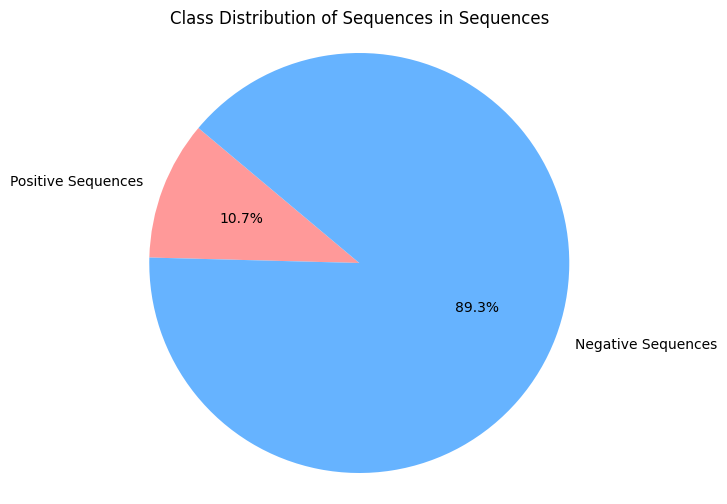

In [ ]:
# Number of positive and negative sequences
num_pos = pos_sequences.shape[0]
num_neg = neg_sequences.shape[0]

# Create an array of labels for the sequences
y = np.array([1] * num_pos + [0] * num_neg)
plot_class_distribution(y, set_name='Sequences', save_dir=IMAGE_DIR)


The displayed arrays are one-hot encoded representations of two different customers' sequential transactions (one from the negative sequences and one from the positive sequence). In this case, we have high dimensional, sparse matrices, which will be computationally expensive to process.

In [ ]:
# Select a random index from the pos_sequences array
random_index = np.random.randint(0, len(pos_sequences))

# Get the sequence at the random index
sample_sequence = pos_sequences[random_index]
display(sample_sequence)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Inactive Transactions

This array represents the transaction types that have not been used by any customer who bought the target product.

In [ ]:
# Create an array of shape (312,) with all zeros to store column sums for all sequences
column_sums = np.zeros((312,))
# Iterate over each sequence in neg_sequences
for pos_sequence in pos_sequences:
    # Sum the sequences along axis 0 to get column sums
    sequence_column_sums = np.sum(pos_sequence, axis=0)
    column_sums += sequence_column_sums

# Find indices where column_sums equals zero
zero_indices_pos = np.where(column_sums == 0)[0]
display(zero_indices_pos)

array([ 20,  56,  64,  65,  69,  71,  75,  91, 109, 111, 112, 142, 147,
       153, 180, 187, 210, 221, 281, 283])


There is no similar pattern for the customers who never bought the targeted product. This indicates that all features exhibit some level of activity across all sequences.

In [ ]:
# Create an array of shape (312,) with all zeros to store column sums for all sequences
column_sums = np.zeros((312,))
# Iterate over each sequence in neg_sequences
for neg_sequence in neg_sequences:
    # Sum the sequences along axis 0 to get column sums
    sequence_column_sums = np.sum(neg_sequence, axis=0)
    column_sums += sequence_column_sums

# Find indices where column_sums equals zero
zero_indices_neg = np.where(column_sums == 0)[0]
display(zero_indices_neg)

array([], dtype=int64)

At first, we considering removing these inactive columns but, we didnot want to loose valuable info. The fact that certain features are inactive (all zeros) for positive sequences is an important pattern. So, we decided to proceed with the columns intact.

## Pre-processing

In [ ]:
# Create labels
pos_labels = np.ones((pos_sequences.shape[0], 1))
neg_labels = np.zeros((neg_sequences.shape[0], 1))

# Combine the positive and negative sequences
X = np.vstack((pos_sequences, neg_sequences))
y = np.vstack((pos_labels, neg_labels))

In [ ]:
# Check the shape of the new arrays
print(X.shape)
print(y.shape)

(111979, 10, 312)
(111979, 1)


## Train/Validation/Test Split

We ensured that the stratification is applied during the splitting process because we want the training and validation sets to be a good representation of the test set. The shapes of the training, validation, and test datasets are as follows: The X_train data, used for training the model, has a shape of (67,187, 10, 312), indicating 67,187 samples, each with sequences of length 10 and 312 features. Correspondingly, the y_train labels have a shape of (67,187, 1). For validation, the X_val data has a shape of (22,396, 10, 312) and the y_val labels have a shape of (22,396, 1). Similarly, the test dataset consists of X_test with a shape of (22,396, 10, 312) and y_test labels with a shape of (22,396, 1).

In [ ]:
# Split the data into training+validation and test sets with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training+validation set into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 * 0.8 = 0.2

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (67187, 10, 312)
X_val shape: (22396, 10, 312)
X_test shape: (22396, 10, 312)
y_train shape: (67187, 1)
y_val shape: (22396, 1)
y_test shape: (22396, 1)


Positive and negative class distributions are all the same along the sets, as expected.

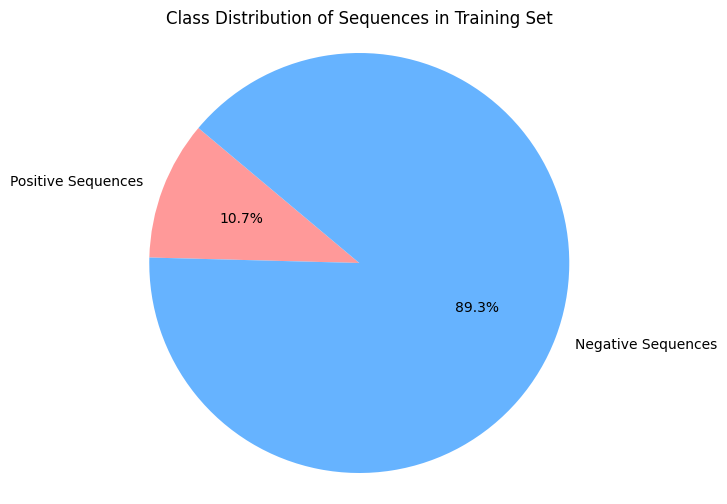

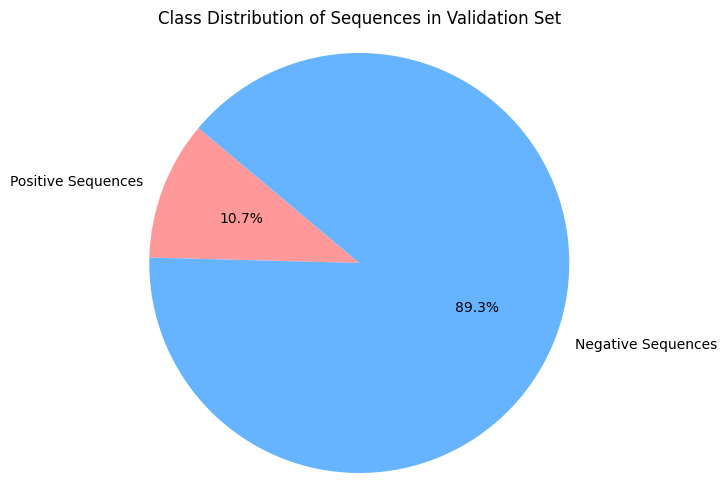

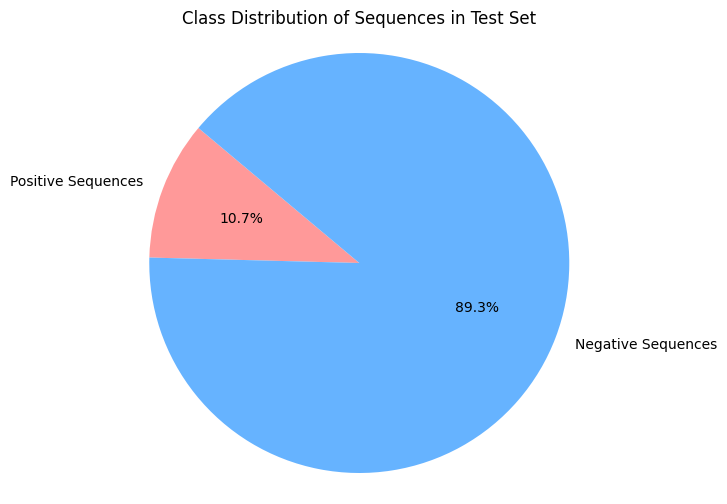

In [ ]:
plot_class_distribution(y_train, 'Training Set')
plot_class_distribution(y_val, 'Validation Set')
plot_class_distribution(y_test, 'Test Set')

## Impact of Duplicates on Model Performance

To better understand the impact of duplicate data on model performance, we conducted a comparative analysis using an LSTM binary classifier trained on sequential transaction data from bank customers. The goal was to classify customers into two categories: those who buy a target product (class 1) and those who don't (class 0). Class 1 is significantly smaller, being ten times less frequent than class 0, indicating a highly imbalanced dataset.

Our analysis compared the model's performance with and without duplicates. Both models achieved similarly high accuracy. The model without duplicates demonstrated better precision, indicating it was more effective at predicting positive cases with fewer false positives. Conversely, the model with duplicates had slightly higher recall, meaning it was marginally better at identifying true positives. However, both models exhibited relatively low recall values, indicating that many positives were missed.

The F1 scores for both models were close, reflecting a balance between precision and recall. The MCC scores suggested that both models performed better than random guessing but still had significant room for improvement. Balanced accuracy was slightly higher for the model with duplicates, suggesting a marginally better performance in handling the class imbalance.

Overall, while the inclusion of duplicates improved recall and balanced accuracy, it did so at the expense of precision. Both models showed moderate performance, highlighting the need for strategies to address the class imbalance more effectively.

We decided not to drop duplicates because they could provide valuable information if they indicate stronger buying behavior, and dropping them did not significantly improve model performance.

In [ ]:
# Prepare data with duplicates
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(neg_sequences, pos_sequences)
model_with_duplicates = build_and_train_model(X_train, y_train, X_val, y_val)
accuracy_with_duplicates, precision_with_duplicates, recall_with_duplicates, f1_with_duplicates, mcc_with_duplicates, balanced_acc = evaluate_model(model_with_duplicates, X_test, y_test)
print("With duplicates - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, , MCC Score: {:.4f}".format(accuracy_with_duplicates, precision_with_duplicates,

# Remove duplicates from negative and positive sequences
unique_neg_sequences = remove_duplicates(neg_sequences)
unique_pos_sequences = remove_duplicates(pos_sequences)

# Prepare data without duplicates
X_train_unique, X_val_unique, X_test_unique, y_train_unique, y_val_unique, y_test_unique = prepare_data(unique_neg_sequences, unique_pos_sequences)
model_without_duplicates = build_and_train_model(X_train_unique, y_train_unique, X_val_unique, y_val_unique)
accuracy_without_duplicates, precision_without_duplicates, recall_without_duplicates, f1_without_duplicates, mcc_without_duplicates, balanced_acc = evaluate_model(model_without_duplicates, X_test_unique, y_test_unique)
print("Without duplicates - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, MCC Score: {:.4f}".format(accuracy_without_duplicates, precision_without_duplicates, recall_without_duplicates,
                                                                                                          f1_without_duplicates, mcc_without_duplicates))


Epoch 1/50
1225/1225 [==============================] - 51s 38ms/step - loss: 0.2725 - accuracy: 0.8985 - val_loss: 0.2296 - val_accuracy: 0.9092
Epoch 2/50
1225/1225 [==============================] - 45s 37ms/step - loss: 0.2318 - accuracy: 0.9080 - val_loss: 0.2240 - val_accuracy: 0.9109
Epoch 3/50
1225/1225 [==============================] - 45s 37ms/step - loss: 0.2269 - accuracy: 0.9107 - val_loss: 0.2222 - val_accuracy: 0.9124
Epoch 4/50
1225/1225 [==============================] - 49s 40ms/step - loss: 0.2223 - accuracy: 0.9120 - val_loss: 0.2222 - val_accuracy: 0.9124
Epoch 5/50
1225/1225 [==============================] - 46s 37ms/step - loss: 0.2201 - accuracy: 0.9132 - val_loss: 0.2246 - val_accuracy: 0.9096
Epoch 6/50
1225/1225 [==============================] - 42s 34ms/step - loss: 0.2177 - accuracy: 0.9134 - val_loss: 0.2208 - val_accuracy: 0.9145
Epoch 7/50
1225/1225 [==============================] - 46s 38ms/step - loss: 0.2157 - accuracy: 0.9143 - val_loss: 0.2213 -

In [ ]:
y_pred_with_duplicates = model_with_duplicates.predict(X_test)
y_pred_classes_with_duplicates = (y_pred_with_duplicates > 0.5).astype(int)

y_pred_without_duplicates = model_without_duplicates.predict(X_test_unique)
y_pred_classes_without_duplicates = (y_pred_without_duplicates > 0.5).astype(int)

479/479 [==============================] - 9s 18ms/step


In [ ]:
balanced_acc_with_duplicates = balanced_accuracy_score(y_test, y_pred_classes_with_duplicates)
balanced_acc_without_duplicates = balanced_accuracy_score(y_test_unique, y_pred_classes_without_duplicates)

print(f"Balanced accuracy with duplicates: {balanced_acc_with_duplicates}")
print(f"Balanced accuracy without duplicates: {balanced_acc_without_duplicates}")

Balanced accuracy with duplicates: 0.677345584422617
Balanced accuracy without duplicates: 0.6655276077948217


In [ ]:
# Generate classification reports for both cases
report_with_duplicates = classification_report(y_test, y_pred_classes_with_duplicates)
report_without_duplicates = classification_report(y_test_unique, y_pred_classes_without_duplicates)

print("Classification Report with duplicates:")
print(report_with_duplicates)

print("Classification Report without duplicates:")
print(report_without_duplicates)

Classification Report with duplicates:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     15058
         1.0       0.64      0.38      0.48      1739

    accuracy                           0.91     16797
   macro avg       0.78      0.68      0.71     16797
weighted avg       0.90      0.91      0.90     16797

Classification Report without duplicates:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     13502
         1.0       0.69      0.35      0.47      1795

    accuracy                           0.91     15297
   macro avg       0.80      0.67      0.71     15297
weighted avg       0.89      0.91      0.89     15297



## Setting a Performance Baseline

Given the high class-imbalance in the dataset, it is crucial to establish a baseline to ensure that the model performs better than a "dumb model," which could achieve deceptively high accuracy by predicting all samples as the dominant class.. To prevent a misleadingly high accuracy, we set a baseline: the accuracy obtained by predicting all samples as the dominant class (class 0). A model must outperform this baseline to be considered effective.

The baseline performance (all zeros) shows high accuracy but zero recall and MCC, indicating it cannot identify any positives. The future models' performance should be significantly better than this baseline in all relevant metrics to be considered successful.

In [ ]:
# Test set shape
test_shape = y_test.shape

# Zero array (baseline model)
zero_array = np.zeros(test_shape).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

# Evaluate the baseline model (predicting all zeros)
print("\nBaseline Performance (All Zeros):")
accuracy = accuracy_score(y_test, zero_array)
precision = precision_score(y_test, zero_array, zero_division=1)
recall = recall_score(y_test, zero_array)
f1 = f1_score(y_test, zero_array)
mcc = matthews_corrcoef(y_test, zero_array)
balanced_accuracy = balanced_accuracy_score(y_test, zero_array)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")



Baseline Performance (All Zeros):
Accuracy: 0.8930
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000
MCC Score: 0.0000
Balanced Accuracy: 0.5000


## Modelling

LSTM (Long Short-Term Memory): LSTM networks are a type of recurrent neural network (RNN) capable of learning order dependence in sequence prediction problems. They are particularly effective for time series forecasting and sequence classification due to their ability to retain long-term dependencies.

### Deep LSTM Classifier

We already built, compiled and trained this model in the previous comparision section. Since it is a binary classification problem, log loss is used as the loss function. The efficient ADAM optimization algorithm is used.

In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Since it is a binary classification problem, log loss is used as the loss function. The efficient ADAM optimization algorithm is used.

In [ ]:
# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1225/1225 [==============================] - 19s 10ms/step - loss: 0.2733 - precision_m: 0.3680 - recall_m: 0.1191 - accuracy: 0.8979 - f1_m: 0.1672 - val_loss: 0.2309 - val_precision_m: 0.6323 - val_recall_m: 0.2253 - val_accuracy: 0.9081 - val_f1_m: 0.3119 - lr: 0.0010
Epoch 2/50
1225/1225 [==============================] - 10s 8ms/step - loss: 0.2322 - precision_m: 0.6276 - recall_m: 0.2915 - accuracy: 0.9076 - f1_m: 0.3754 - val_loss: 0.2246 - val_precision_m: 0.6227 - val_recall_m: 0.3073 - val_accuracy: 0.9105 - val_f1_m: 0.3899 - lr: 0.0010
Epoch 3/50
1225/1225 [==============================] - 17s 14ms/step - loss: 0.2273 - precision_m: 0.6486 - recall_m: 0.3217 - accuracy: 0.9096 - f1_m: 0.4070 - val_loss: 0.2217 - val_precision_m: 0.6456 - val_recall_m: 0.3053 - val_accuracy: 0.9123 - val_f1_m: 0.3947 - lr: 0.0010
Epoch 4/50
1225/1225 [==============================] - 11s 9ms/step - loss: 0.2236 - precision_m: 0.6499 - recall_m: 0.3371 - accuracy: 0.9112 - f1_m: 

Model is learning effectively from the training data since itis minimizing the loss function on the training data. But it is not improving further on the validation data after a certain point. As we understand from the pattern accuracy and loss graphs below, the model is over-fitting. This is characterized by the training accuracy and loss continuing to improve while the validation metrics do not show similar improvements after a certain point.

In [ ]:
os.makedirs(MODEL_DIR, exist_ok=True)
model_name = "Binary_Classification_Model_with_LSTM"
# save the model and its weights
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


As we observe the loss and accuracy graphs below, we clearly understand that the model continues learning on the training set, but after a few epoch training stops on the validation set. That is why there is a accuracy gap in between training and validation sets. This is an implication of over-fitting.

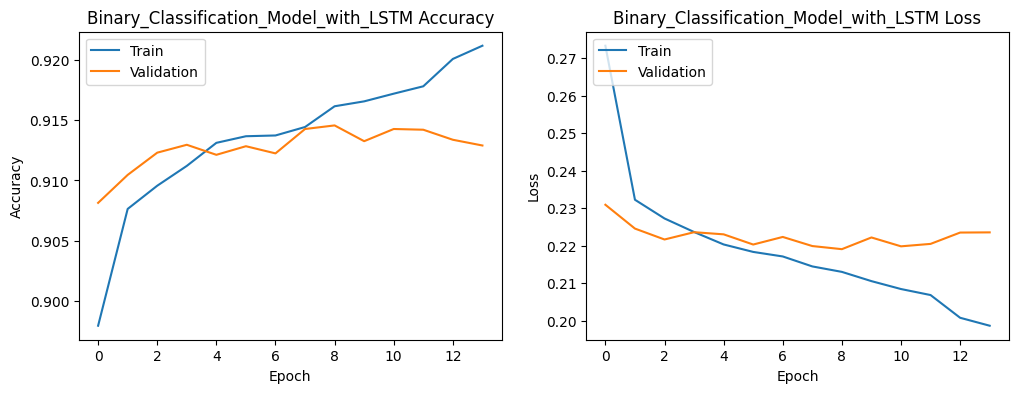

In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

The model's performance metrics on the test set indicate a reasonably high accuracy of 91.30%, suggesting that it correctly classified the majority of the instances. However, precision, which measures the proportion of correctly identified positive cases among all cases classified as positive, is moderate at 67.15%. This indicates that there is a notable number of false positives in the predictions. Similarly, the recall rate, representing the proportion of actual positive cases that were correctly identified by the model, is relatively low at 36.52%, indicating that the model missed a significant portion of positive instances. Consequently, the F1 score, which combines precision and recall into a single metric, stands at 47.31%, suggesting a fair balance between precision and recall but still leaving room for improvement, particularly in terms of recall.

In [ ]:
# Construct the full path to the model file
model_name = "Binary_Classification_Model_with_LSTM"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

700/700 [==============================] - 8s 10ms/step


In [ ]:
accuracy, precision, recall, f1, mcc, balanced_acc = evaluate_model(model, X_test, y_test)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

700/700 [==============================] - 8s 12ms/step
Accuracy: 0.9190
Precision: 0.7530
Recall: 0.3614
F1 Score: 0.4884
MCC Score: 0.4863
Balanced Accuracy: 0.6736


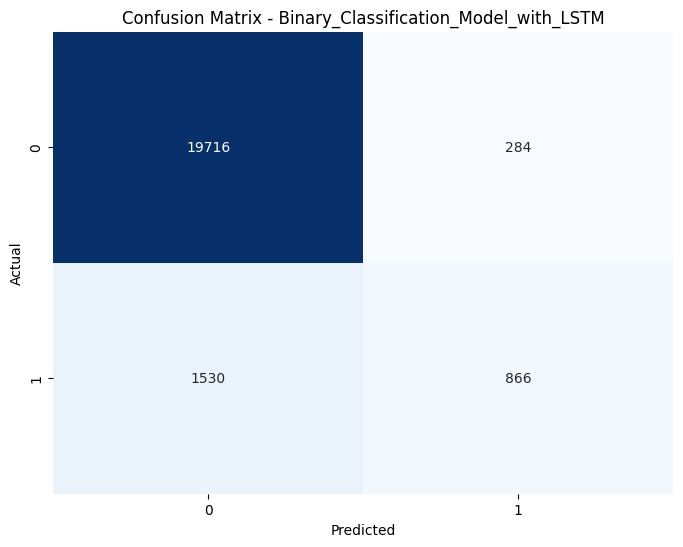

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

#### Model Calibration

The blue line represents the fraction of positive outcomes predicted by the model at various probability thresholds. The dashed orange line indicates perfect calibration. When the blue line falls below the orange line, the model is overestimating the likelihood of positive outcomes. Conversely, when it is above the dashed line, the model is underestimating the likelihood of positive outcomes. Overall, our calibration curve is close to perfect, though it deviates in some areas.

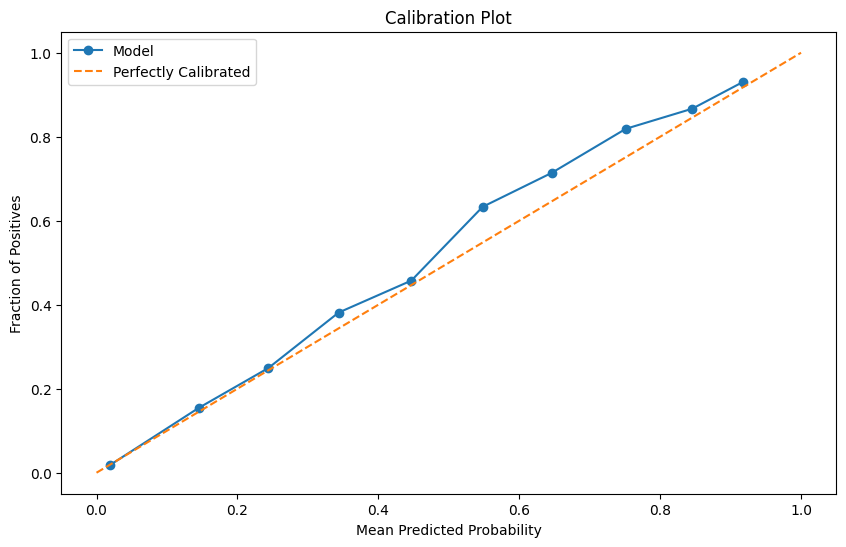

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

#### Threshold Adjustment

##### F1 Optimized

 Based on our predictions may be the bank run a marketing campaign to candidate customers. Assuming that losing a promising customer is costly for the bank, you should focus on optimizing your model to minimize false negatives (i.e., customers who are predicted not to buy the product but actually would). To adjust the balance between precision and recall we lowered the probability threshold. Lowering the decision threshold can increase recall at the expense of precision, which might be acceptable in this case.

The Deep LSTM Classifier with the default threshold performs better in terms of accuracy and precision, which means it is more reliable in predicting positive cases correctly without many false positives.
The Threshold Adjusted Deep LSTM Classifier excels in recall, F1-score, MCC, and balanced accuracy. This indicates it is better at identifying true positives and providing a more balanced performance across both classes, despite having a lower overall accuracy.

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

Best Threshold: 0.2599999999999999
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.9025
Balanced Accuracy: 0.7757
Precision: 0.5390
Recall: 0.6144
F1 Score: 0.5742
MCC: 0.5209


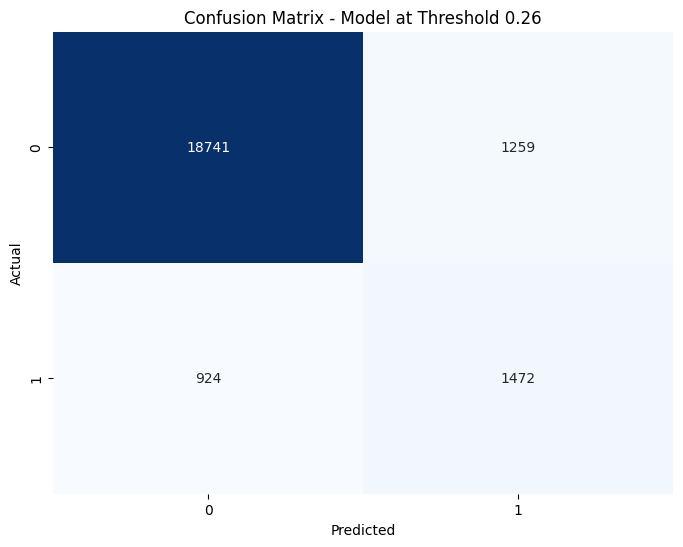

In [ ]:
# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

##### MCC Optimized

In [ ]:
# Load the model
MODEL_DIR = './models'
model_name = "Binary_Classification_Model_with_LSTM"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")

# Load the saved model with custom metrics
model = load_model(model_path, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

700/700 [==============================] - 13s 17ms/step
Best Threshold: 0.2599999999999999
Metrics at Best Threshold for Balanced MCC Score:
Accuracy: 0.9025
Balanced Accuracy: 0.7757
Precision: 0.5390
Recall: 0.6144
F1 Score: 0.5742
MCC: 0.5209


### Regularized Deep LSTM Classifier

To tackle the over-fitting problem, we decided to utilize a regularization technique: **L2 regularization**. It is also known as *weight decay*, and penalizes the loss function proportional proportional to the square of the magnitudes of the weights. This way, it encourages the weights to remain small during training and helps us prevent overfitting by discouraging the model from fitting the noise in the training data.


In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
               kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(LSTM(64, kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01

# Display the model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_8 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1050/1050 [==============================] - 56s 47ms/step - loss: 0.3121 - precision_m: 0.2705 - recall_m: 0.0595 - accuracy: 0.8950 - f1_m: 0.0916 - val_loss: 0.3067 - val_precision_m: 0.3740 - val_recall_m: 0.0799 - val_accuracy: 0.8969 - val_f1_m: 0.1267 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 47s 45ms/step - loss: 0.3101 - precision_m: 0.2930 - recall_m: 0.0632 - accuracy: 0.8957 - f1_m: 0.0978 - val_loss: 0.3092 - val_precision_m: 0.0571 - val_recall_m: 0.0077 - val_accuracy: 0.8938 - val_f1_m: 0.0134 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 43s 41ms/step - loss: 0.3103 - precision_m: 0.2722 - recall_m: 0.0583 - accuracy: 0.8957 - f1_m: 0.0912 - val_loss: 0.3079 - val_precision_m: 0.0871 - val_recall_m: 0.0130 - val_accuracy: 0.8941 - val_f1_m: 0.0223 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 42s 40ms/step - loss: 0.3094 - precision_m: 0.2598 - recall_m: 0.0578 - accuracy: 0.8950 - f1_m

In [ ]:
# Load the model
MODEL_DIR = './models'
model_name = "Binary_Classification_Model_with_L2_Regularization"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")

# Load the saved model with custom metrics
model = load_model(model_path, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# Verify the model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_8 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_name = "Binary_Classification_Model_with_L2_Regularization"
custom_objects={'precision_m': precision_m, 'recall_m': recall_m,
                                               'f1_m': f1_score}
model = load_saved_model(MODEL_DIR, model_name, custom_objects)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_8 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Assuming X_train, y_train, X_val, and y_val are your training and validation data
new_epochs = 50  # Number of additional epochs to train

# Continue training
history_continued = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=new_epochs,
    initial_epoch=len(history['accuracy']),
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 26/50
1050/1050 [==============================] - 49s 43ms/step - loss: 0.2974 - precision_m: 0.4250 - recall_m: 0.1050 - accuracy: 0.8978 - f1_m: 0.1599 - val_loss: 0.2991 - val_precision_m: 0.5143 - val_recall_m: 0.1411 - val_accuracy: 0.8991 - val_f1_m: 0.2094 - lr: 1.0000e-04
Epoch 27/50
1050/1050 [==============================] - 51s 49ms/step - loss: 0.2969 - precision_m: 0.4250 - recall_m: 0.1022 - accuracy: 0.8978 - f1_m: 0.1572 - val_loss: 0.3025 - val_precision_m: 0.5222 - val_recall_m: 0.1597 - val_accuracy: 0.8994 - val_f1_m: 0.2296 - lr: 1.0000e-04
Epoch 28/50
1050/1050 [==============================] - 45s 43ms/step - loss: 0.2970 - precision_m: 0.4270 - recall_m: 0.1043 - accuracy: 0.8981 - f1_m: 0.1597 - val_loss: 0.2977 - val_precision_m: 0.4174 - val_recall_m: 0.0908 - val_accuracy: 0.8975 - val_f1_m: 0.1430 - lr: 1.0000e-04
Epoch 29/50
1050/1050 [==============================] - 47s 45ms/step - loss: 0.2967 - precision_m: 0.4295 - recall_m: 0.1037 - accurac

In [ ]:
# Save the updated model
model.save(model_path)

# Combine old and new history
for key in history_continued.history:
    if key in history:
        history[key].extend(history_continued.history[key])
    else:
        history[key] = history_continued.history[key]

# Save the updated history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history, file)


The training accuracy shows an overall upward trend with fluctuations, stabilizing around 0.898. The validation loss initially fluctuates but then aligns closely with the training loss, suggesting that the model is not significantly overfitting. The training accuracy shows steady improvement, indicating effective learning from the training data. The validation accuracy's fluctuations suggest variability in performance on unseen data, but the overall trend is stable and close to the training accuracy. Both training and validation loss decrease over time, which is a good sign. The initial fluctuations in validation loss followed by stabilization indicate that the model is learning effectively.

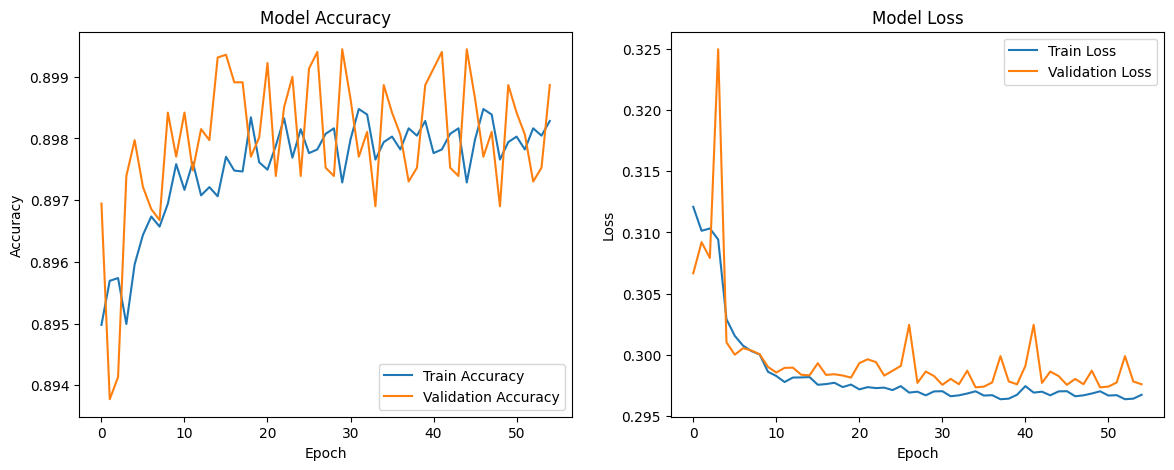

In [ ]:
# Plot the combined history
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


The application of L2 regularization has not improved the model's performance in this case. The accuracy, precision, recall, MCC score, and even The balanced accuracy decreased after L2 regularization. It may have introduced underfitting, leading to poorer metrics.

In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 9s 12ms/step
Accuracy: 0.8977
Precision: 0.6300
Recall: 0.1052
F1 Score: 0.1803
MCC Score: 0.2282
Balanced Accuracy: 0.5489


(0.8976602964815146,
 0.63,
 0.10517529215358931,
 0.18025751072961374,
 0.2281842558262604,
 0.5488876460767946)

700/700 [==============================] - 10s 14ms/step


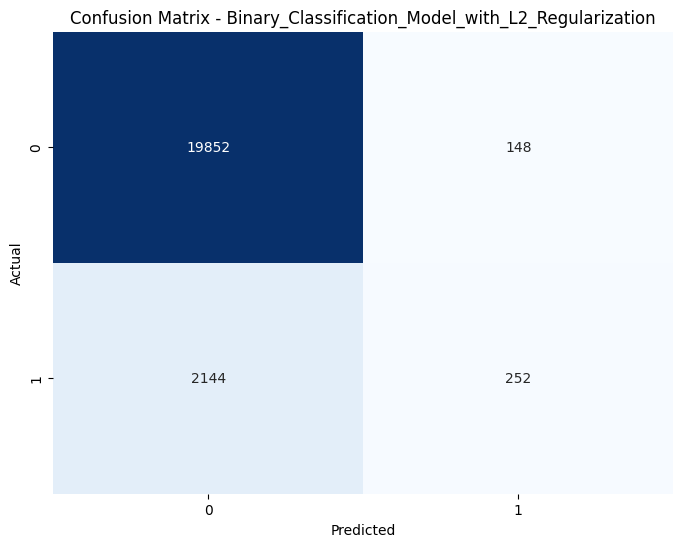

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

#### Model Calibration

The model demonstrates good calibration at lower probabilities (0.1 to 0.3), closely following the perfect calibration line. However, it underestimates positive outcomes at around 0.4, as the blue line falls below the orange line, and overestimates at higher probabilities (0.8 to 1.0), where the blue line rises above the orange line. This indicates that the model is less confident than it should be at moderate probabilities and overly confident at high probabilities.

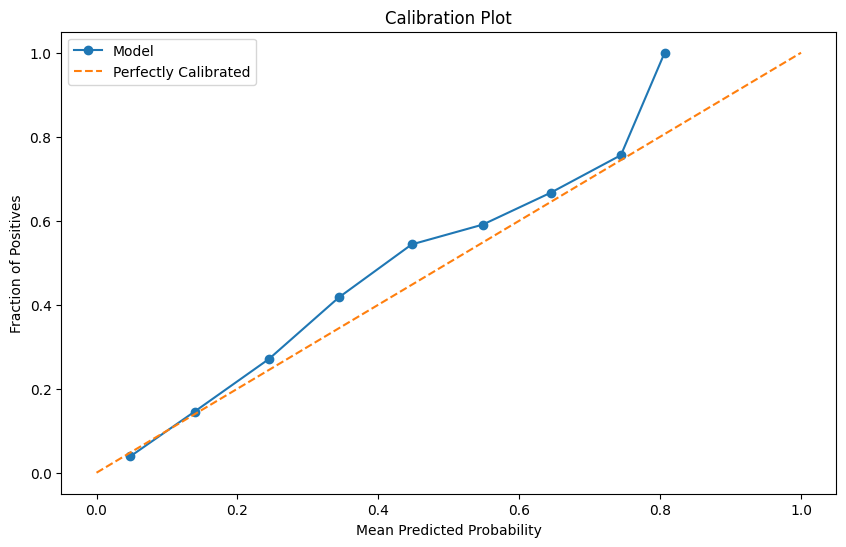

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

#### Threshold Adjustment

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

NameError: name 'model' is not defined

When we optimized the probability threshold using the MCC score, all metrics worsened. The model optimized for the balanced F1 score is the best choice. It offers a good balance across all metrics, especially in handling class imbalance, and achieves the highest MCC, indicating robust performance in predicting positive outcomes in your dataset. Notably, it gives the highest recall score, which is better for our business case.

In [ ]:
thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_best_threshold_by_mcc(y_test, y_test_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced MCC Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

Best Threshold: 0.21999999999999995
Metrics at Best Threshold for Balanced MCC Score:
Accuracy: 0.8724
Balanced Accuracy: 0.6942
Precision: 0.4147
Recall: 0.4674
F1 Score: 0.4395
MCC: 0.3686


### Regularized Deep LSTM Classifier with Large Batch Size


In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
               kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(LSTM(64, kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # not Adding L2 regularization with lambda = 0.01

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[precision_m, recall_m, 'accuracy', f1_m])
history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
525/525 [==============================] - 47s 78ms/step - loss: 0.5957 - precision_m: 1.5792e-04 - recall_m: 2.5510e-04 - accuracy: 0.8920 - f1_m: 1.7952e-04 - val_loss: 0.3357 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 2/50
525/525 [==============================] - 42s 80ms/step - loss: 0.3357 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3424 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 3/50
525/525 [==============================] - 43s 82ms/step - loss: 0.3319 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3248 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 4/50
525/525 [==============================] - 37s 70ms/step - loss: 0.3282 - 

In [ ]:
os.makedirs(MODEL_DIR, exist_ok=True)
model_name = "Binary_Classification_Model_with_L2_Regularization_Large_Batches"
# save the model and its weights
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

The model shows good convergence as both training and validation accuracies and losses follow similar trends and stabilize.
The slight fluctuation in validation accuracy indicates some variance, but overall, the model does not appear to overfit significantly.
The use of L2 regularization helps in controlling overfitting, and this is evident in the similar performance between the training and validation sets.

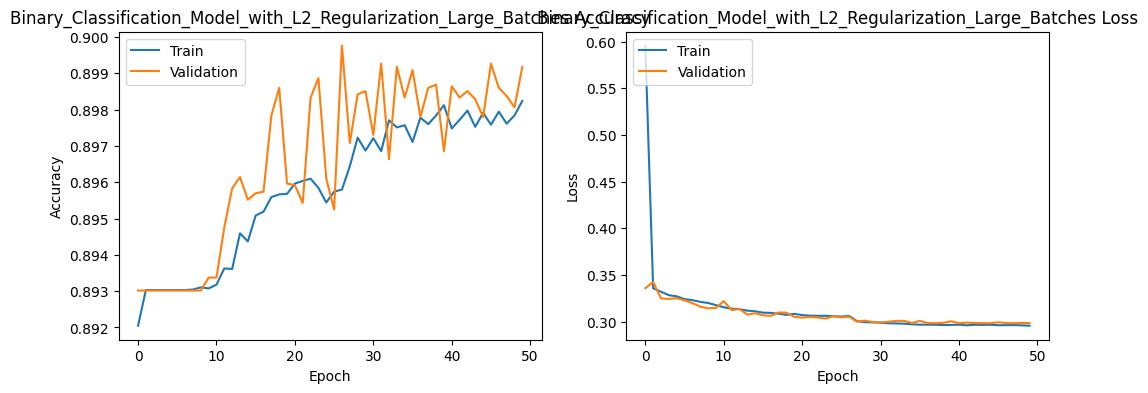

Plots saved as images/Binary_Classification_Model_with_L2_Regularization_Large_Batches_accuracy.png and images/Binary_Classification_Model_with_L2_Regularization_Large_Batches_loss.png


In [ ]:
model_name = 'Binary_Classification_Model_with_L2_Regularization_Large_Batches'
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

The high accuracy with very low recall suggests that the model is likely biased towards the negative class. This is common in imbalanced datasets where the majority class dominates the prediction. Both F1 and MCC metrics are low, which further emphasizes that the model's performance, especially for the positive class, is suboptimal.

In [ ]:
# Load the model
model_name = "Binary_Classification_Model_with_L2_Regularization_Large_Batches"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")

# Load the saved model with custom metrics
model = load_model(model_path, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# Verify the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 9s 11ms/step
Accuracy: 0.8968
Precision: 0.6232
Recall: 0.0897
F1 Score: 0.1569
MCC Score: 0.2089
Balanced Accuracy: 0.5416


(0.896811930701911,
 0.6231884057971014,
 0.08973288814691152,
 0.1568770521707406,
 0.2088957850870917,
 0.5416164440734558)

The model is highly effective in identifying negative cases but has difficulty with positive cases, as shown by the low recall and true positive count.

700/700 [==============================] - 9s 13ms/step


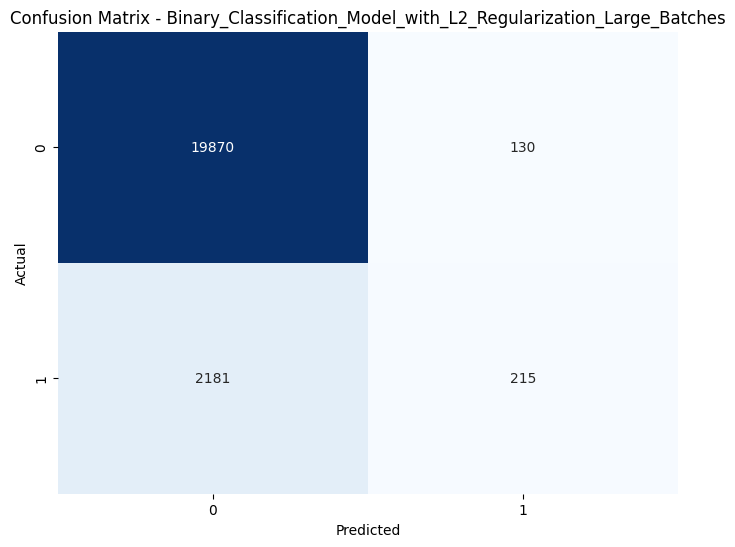

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

#### Model Calibration

The calibration plot suggests that while our last model is reasonably well-calibrated for lower probabilities, there is room for improvement in the mid and high probability ranges.

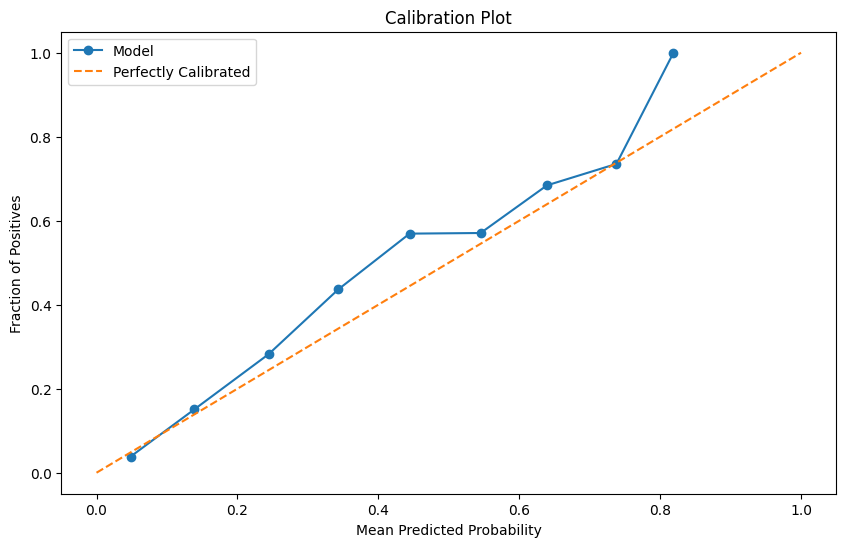

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

#### Threshold Adjustment

Best Threshold: 0.17
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.8486
Balanced Accuracy: 0.7225
Precision: 0.3651
Recall: 0.5622
F1 Score: 0.4427
MCC: 0.3709


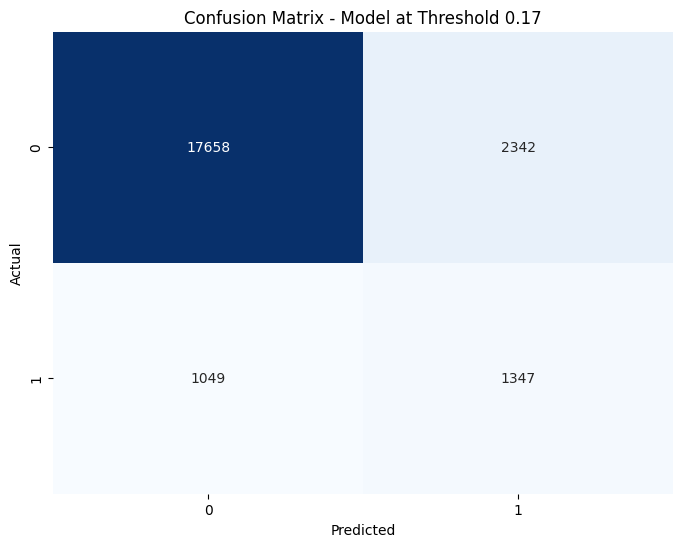

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

+ The Deep LSTM Classifier With Duplicates has a higher recall compared to the one without duplicates. Since recall is more critical for our application, it is a good choice not drop the duplicates.

+ Regularized models optimized for F1 and MCC scores show better recall compared to the regularized model with a standard threshold of 0.5. So, we kept regularizing the models.

+ Our primary concern is recall. he F1 optimized models outperform the MCC optimized ones in terms of recall since the F1 score is more sensitive to changes in recall compared to MCC. That's why we will be adjusting the probability thresholds according to the F1-score.

+ Increasing the batch size did not help improve recall or F1 score. Thus, we will be working with the standart batch size of 64. Such a small size leads to noisier updates ass seen from the training history graphs, but at the same time it provides a more accurate estimate of the gradient because it updates the model more frequently.

+ While adding more units to the layers provides a decent improvement, the high capacity models donot outperform the F1 and MCC optimized models in recall and other balanced metrics. So, we decided to keep our number of units as 64.

| Model                                                 | Threshold | Accuracy | Precision | Recall | F1 Score | MCC Score | Balanced Accuracy |
|-------------------------------------------------------|-----------|----------|-----------|--------|----------|-----------|-------------------|
| Baseline Performance (All Zeros)                      | -         | 0.8930   | 1.0000    | 0.0000 | 0.0000   | 0.0000    | 0.5000            |
| Deep LSTM Classifier With Duplicates                  | 0.5       | 0.9135   | 0.6383    | 0.3795 | 0.4760   | 0.4496    | 0.6773            |
| Deep LSTM Classifier Without Duplicates               | 0.5       | 0.9054   | 0.6900    | 0.3521 | 0.4662   | 0.4490    | 0.6655            |
| Deep LSTM Classifier                                  | 0.5       | 0.9190   | 0.7530    | 0.3614 | 0.4884   | 0.4863    | 0.6736            |
| F1 Optimized LSTM Classifier                          | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| MCC Optimized LSTM Classifier                         | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| Regularized Deep LSTM Classifier                      | 0.5       | 0.8977   | 0.6300    | 0.1052 | 0.1803   | 0.2282    | 0.5489            |
| F1 Optimized Regularized LSTM Classifier              | 0.2       | 0.8625   | 0.3902    | 0.5071 | 0.4410   | 0.3682    | 0.7061            |
| MCC Optimized Regularized LSTM Classifier             | 0.22      | 0.8724   | 0.4147    | 0.4674 | 0.4395   | 0.3686    | 0.6942            |
| Regularized Deep LSTM Classifier with Large Batch Size| 0.5       | 0.8968   | 0.6232    | 0.0897 | 0.1569   | 0.2089    | 0.5416            |
| F1 Optimized Regularized Deep LSTM Classifier with Large Batch Size | 0.17 | 0.8486 | 0.3651 | 0.5622 | 0.4427 | 0.3709 | 0.7225 |
| High-Capacity Deep LSTM Classifier                    | 0.5       | 0.9100   | 0.6631    | 0.3836 | 0.4860   | 0.4621    | 0.6801            |
| F1 Optimized High-Capacity Deep LSTM Classifier       | 0.28      | 0.8935   | 0.5019    | 0.5968 | 0.5453   | 0.4878    | 0.7629            |


### High-Capacity Deep LSTM Classifier

To boost the performance of the model we increased the number of units of each LSTM layer. With more units, LSTM layers gain increased representational power, allowing them to extract richer features and discern subtle variations in the input sequences. This results in improved learning ability, as the model becomes better equipped to adapt to the complexities of the data distribution and capture long-term dependencies. However, increasing the number of units also introduces the risk of overfitting, which can be mitigated through regularization techniques. That's why we increased the drop-out rate from 0.3 to 0.5 at the same time.

In [ ]:
model = Sequential()
# Adding LSTM layers with increased units
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
# Adding a Dense layer for classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val) ,callbacks=[early_stopping,
                                                               reduce_lr]) #

Epoch 1/50
1050/1050 [==============================] - 126s 104ms/step - loss: 0.2870 - precision_m: 0.3192 - recall_m: 0.1038 - accuracy: 0.8980 - f1_m: 0.1457 - val_loss: 0.2410 - val_precision_m: 0.6212 - val_recall_m: 0.2964 - val_accuracy: 0.9082 - val_f1_m: 0.3798 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 97s 92ms/step - loss: 0.2404 - precision_m: 0.6150 - recall_m: 0.2994 - accuracy: 0.9073 - f1_m: 0.3757 - val_loss: 0.2362 - val_precision_m: 0.6386 - val_recall_m: 0.2703 - val_accuracy: 0.9084 - val_f1_m: 0.3589 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 110s 105ms/step - loss: 0.2338 - precision_m: 0.6266 - recall_m: 0.3285 - accuracy: 0.9093 - f1_m: 0.4044 - val_loss: 0.2300 - val_precision_m: 0.6615 - val_recall_m: 0.3285 - val_accuracy: 0.9117 - val_f1_m: 0.4154 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 94s 90ms/step - loss: 0.2299 - precision_m: 0.6403 - recall_m: 0.3435 - accuracy: 0.9105 - 

In [ ]:
os.makedirs(MODEL_DIR, exist_ok=True)
model_name = "HighCapacity_Binary_Classification_Model"
# save the model and its weights
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Oh, that was a bad idea! Model over-fitted again!

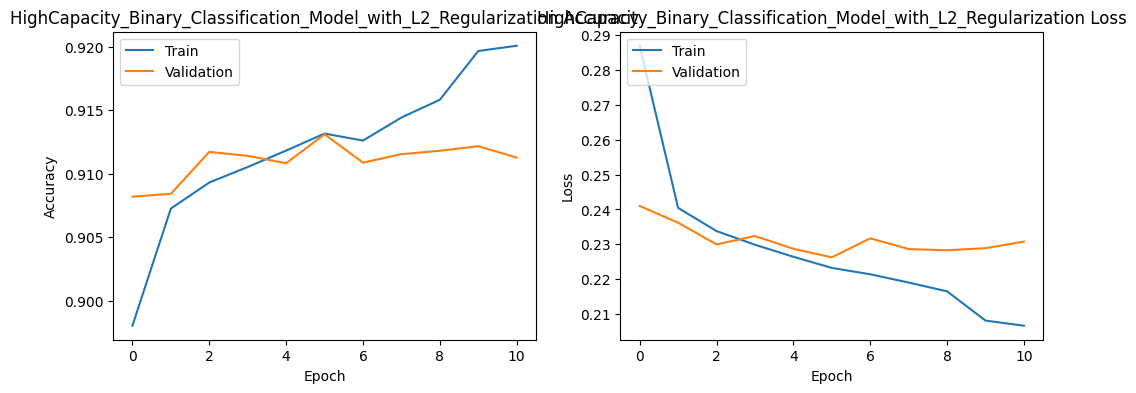

Plots saved as images/HighCapacity_Binary_Classification_Model_with_L2_Regularization_accuracy.png and images/HighCapacity_Binary_Classification_Model_with_L2_Regularization_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
# Use the function to print metrics for the test set
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 25s 34ms/step
Accuracy: 0.9132
Precision: 0.6631
Recall: 0.3836
F1 Score: 0.4860
MCC Score: 0.4621
Balanced Accuracy: 0.6801


(0.9131987854974103,
 0.663059163059163,
 0.3835559265442404,
 0.48598625066102585,
 0.4620772824764399,
 0.6801029632721203)

700/700 [==============================] - 16s 23ms/step


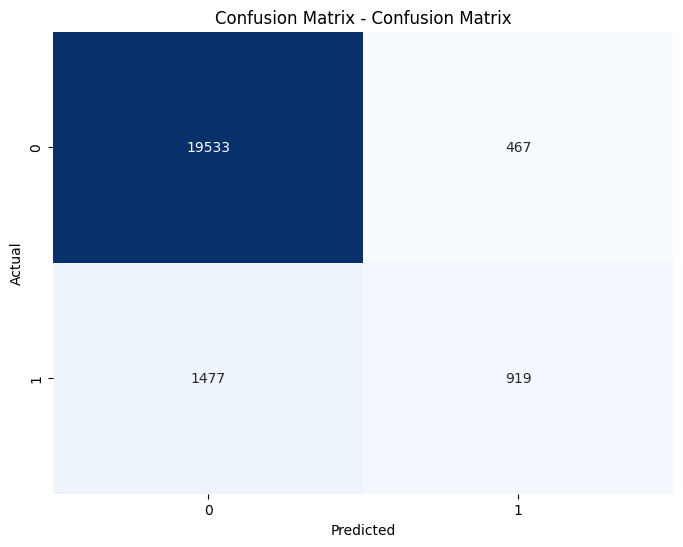

In [ ]:
# Generate predictions for the test set using the best model
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, 'Confusion Matrix')

# Display the plot
plt.show()

##### Model Calibration

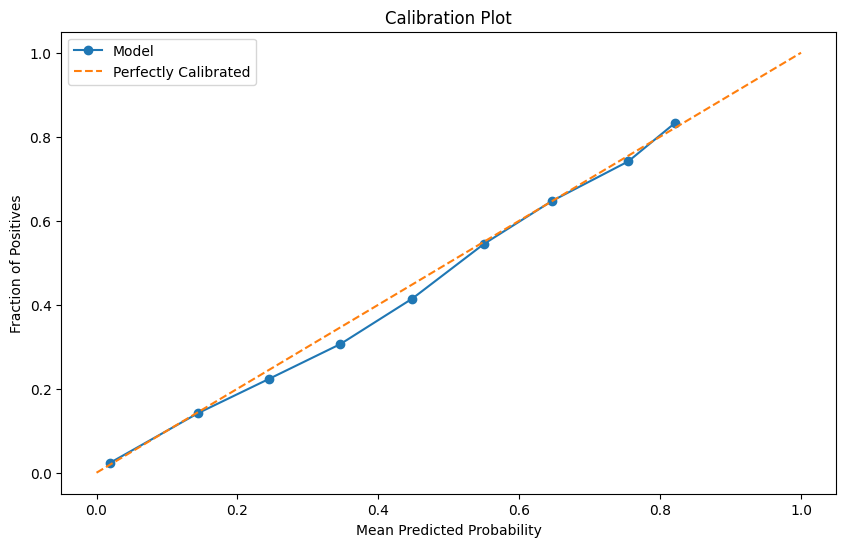

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

#### Threshold Adjustment

Best Threshold: 0.28
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.8935
Balanced Accuracy: 0.7629
Precision: 0.5019
Recall: 0.5968
F1 Score: 0.5453
MCC: 0.4878


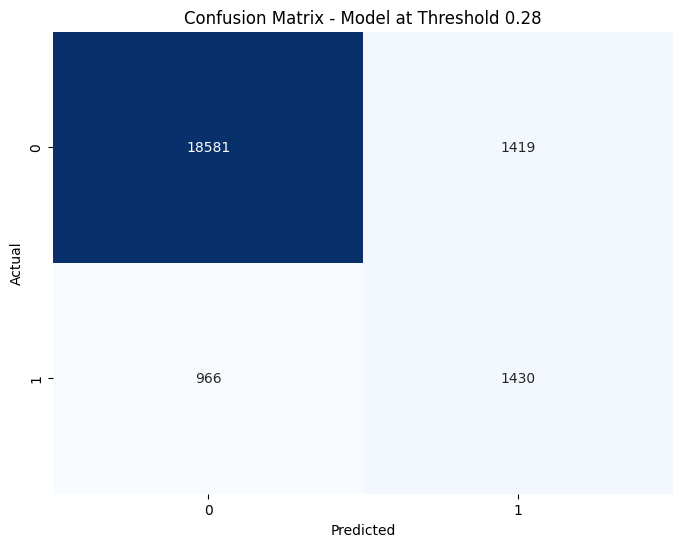

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

### High Capacity Regularized LSTM Classifier

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
               kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Adding L2 regularization with lambda = 0.01
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # not Adding L2 regularization with lambda = 0.01

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val) ,callbacks=[early_stopping,
                                                               reduce_lr]) #

Epoch 1/50
1050/1050 [==============================] - 141s 125ms/step - loss: 0.4937 - precision_m: 1.0582e-04 - recall_m: 4.0816e-04 - accuracy: 0.8926 - f1_m: 1.6807e-04 - val_loss: 0.3431 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 114s 109ms/step - loss: 0.3348 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3434 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 104s 99ms/step - loss: 0.3293 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3303 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 110s 105ms/step - 

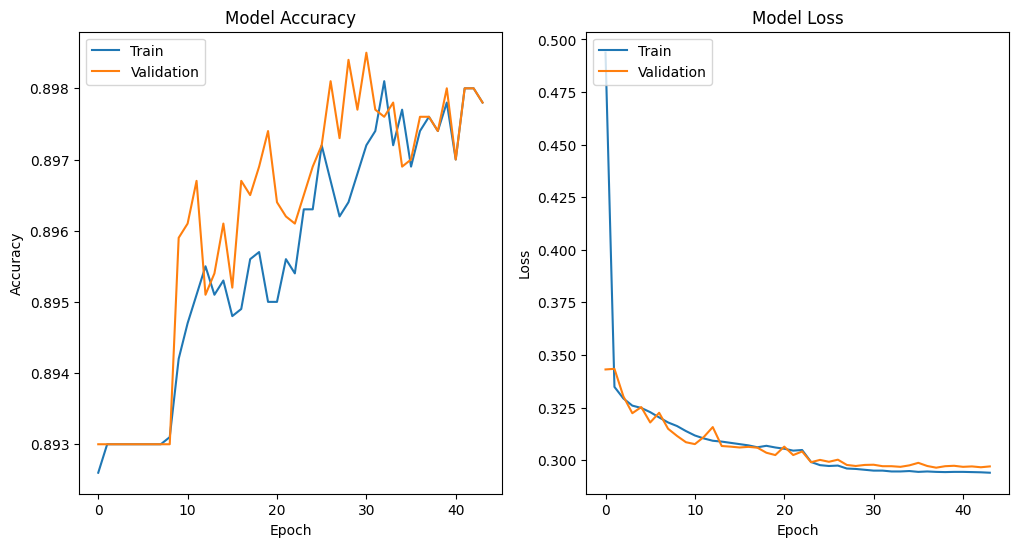

In [ ]:
import matplotlib.pyplot as plt

# Manually parsed training history
history = {
    'loss': [0.4937, 0.3348, 0.3293, 0.3259, 0.3248, 0.3228, 0.3203, 0.3179, 0.3162, 0.3138,
             0.3117, 0.3103, 0.3092, 0.3088, 0.3082, 0.3076, 0.3070, 0.3061, 0.3068, 0.3060,
             0.3054, 0.3045, 0.3048, 0.2991, 0.2976, 0.2972, 0.2974, 0.2960, 0.2958, 0.2954,
             0.2950, 0.2950, 0.2946, 0.2946, 0.2948, 0.2944, 0.2946, 0.2944, 0.2943, 0.2944,
             0.2944, 0.2943, 0.2942, 0.2940],
    'val_loss': [0.3431, 0.3434, 0.3303, 0.3223, 0.3252, 0.3179, 0.3225, 0.3149, 0.3115, 0.3085,
                 0.3076, 0.3110, 0.3157, 0.3067, 0.3064, 0.3060, 0.3063, 0.3059, 0.3035, 0.3024,
                 0.3064, 0.3024, 0.3041, 0.2990, 0.3001, 0.2992, 0.3002, 0.2977, 0.2972, 0.2977,
                 0.2978, 0.2971, 0.2971, 0.2968, 0.2975, 0.2987, 0.2972, 0.2964, 0.2971, 0.2973,
                 0.2968, 0.2970, 0.2966, 0.2970],
    'accuracy': [0.8926, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8931, 0.8942,
                 0.8947, 0.8951, 0.8955, 0.8951, 0.8953, 0.8948, 0.8949, 0.8956, 0.8957, 0.8950,
                 0.8950, 0.8956, 0.8954, 0.8963, 0.8963, 0.8972, 0.8967, 0.8962, 0.8964, 0.8968,
                 0.8972, 0.8974, 0.8981, 0.8972, 0.8977, 0.8969, 0.8974, 0.8976, 0.8974, 0.8978,
                 0.8970, 0.8980, 0.8980, 0.8978],
    'val_accuracy': [0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8930, 0.8959,
                     0.8961, 0.8967, 0.8951, 0.8954, 0.8961, 0.8952, 0.8967, 0.8965, 0.8969, 0.8974,
                     0.8964, 0.8962, 0.8961, 0.8965, 0.8969, 0.8972, 0.8981, 0.8973, 0.8984, 0.8977,
                     0.8985, 0.8977, 0.8976, 0.8978, 0.8969, 0.8970, 0.8976, 0.8976, 0.8974, 0.8980,
                     0.8970, 0.8980, 0.8980, 0.8978]
}

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
import pickle
import json
from tensorflow.keras.callbacks import ModelCheckpoint

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Model name
model_name = "HighCapacity_RegularizedLSTM_Binary_Classification_Model"

# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1050/1050 [==============================] - 100s 90ms/step - loss: 0.4942 - precision_m: 1.5873e-04 - recall_m: 3.8095e-04 - accuracy: 0.8927 - f1_m: 2.2409e-04 - val_loss: 0.3404 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 2/50
   1/1050 [..............................] - ETA: 1:04 - loss: 0.3436 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8750 - f1_m: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1050/1050 [==============================] - 107s 102ms/step - loss: 0.3331 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3287 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 78s 74ms/step - loss: 0.3257 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3238 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 5/50
1050/1050 [==============================] - 81s 77ms/step - loss: 0.3238 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - accuracy: 0.8930 - f1_m: 0.0000e+00 - val_loss: 0.3194 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_accuracy: 0.8930 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 6/50
1050/1050 [==============================] - 77s 73ms/step - loss: 0.3225 - p

TypeError: Object of type float32 is not JSON serializable

In [ ]:
# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)


The model has a low recall, F1-score, and moderate precision. It struggles to identify positive cases an there is an imbalance between precision and recall.

In [ ]:
# Use the function to print metrics for the test set
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 15s 20ms/step
Accuracy: 0.8970
Precision: 0.6233
Recall: 0.0939
F1 Score: 0.1632
MCC Score: 0.2138
Balanced Accuracy: 0.5436


(0.8969905340239328,
 0.6232686980609419,
 0.09390651085141903,
 0.1632208922742111,
 0.2137956646089326,
 0.5435532554257095)

700/700 [==============================] - 14s 20ms/step


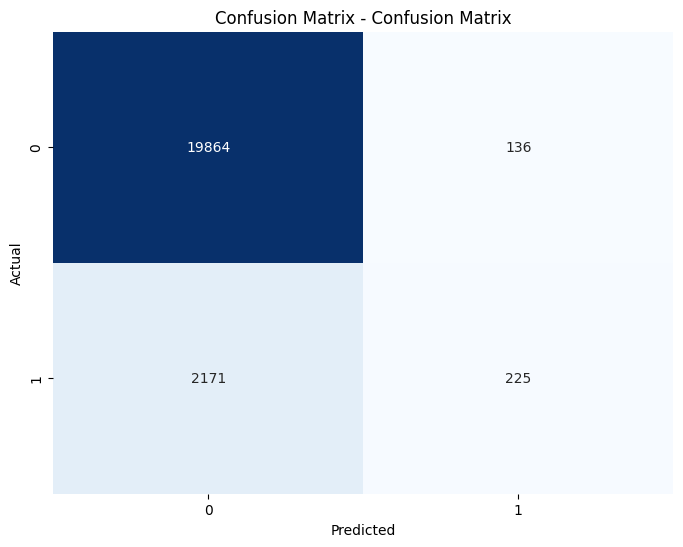

In [ ]:
# Generate predictions for the test set using the best model
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, 'Confusion Matrix')

# Display the plot
plt.show()

#### Model Calibration

The model appears to be underconfident for probabilities in the lower range (0.0 to 0.4) and overconfident in the higher range (above 0.6). This indicates that the predicted probabilities do not align well with the observed frequencies of positives.

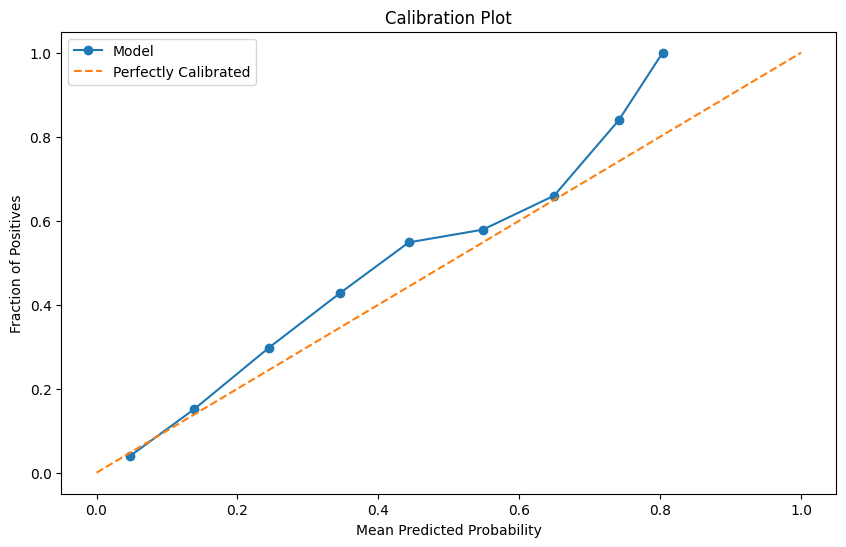

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

#### Threshold Adjustment

After optimizing the threshold using the F1 score, there is a significant improvement in recall, highlighting the model's enhanced ability to detect positive cases, which was previously a major issue. Additionally, the balanced accuracy, F1 score, and MCC have all increased, indicating that the model is now performing more consistently across both classes.

Best Threshold: 0.2
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.8685
Balanced Accuracy: 0.6988
Precision: 0.4040
Recall: 0.4829
F1 Score: 0.4399
MCC: 0.3679


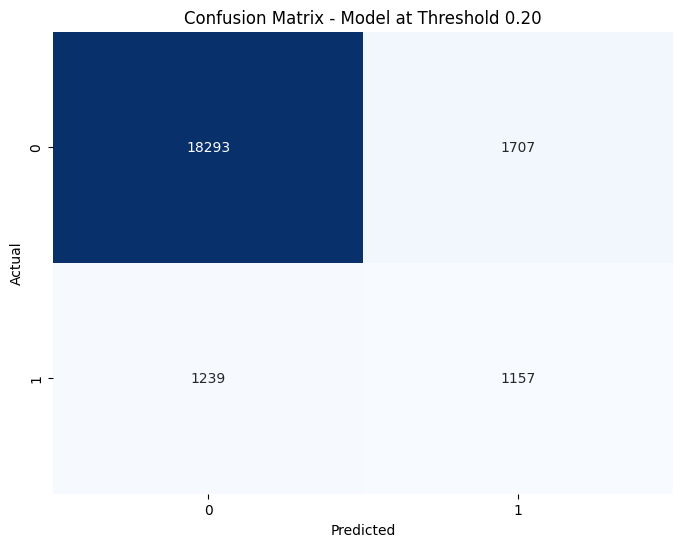

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')


| Model                                                 | Threshold | Accuracy | Precision | Recall | F1 Score | MCC Score | Balanced Accuracy |
|-------------------------------------------------------|-----------|----------|-----------|--------|----------|-----------|-------------------|
| Baseline Performance (All Zeros)                      | -         | 0.8930   | 1.0000    | 0.0000 | 0.0000   | 0.0000    | 0.5000            |
| Deep LSTM Classifier With Duplicates                  | 0.5       | 0.9135   | 0.6383    | 0.3795 | 0.4760   | 0.4496    | 0.6773            |
| Deep LSTM Classifier Without Duplicates               | 0.5       | 0.9054   | 0.6900    | 0.3521 | 0.4662   | 0.4490    | 0.6655            |
| Deep LSTM Classifier                                  | 0.5       | 0.9190   | 0.7530    | 0.3614 | 0.4884   | 0.4863    | 0.6736            |
| F1 Optimized LSTM Classifier                          | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| MCC Optimized LSTM Classifier                         | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| Regularized Deep LSTM Classifier                      | 0.5       | 0.8977   | 0.6300    | 0.1052 | 0.1803   | 0.2282    | 0.5489            |
| F1 Optimized Regularized LSTM Classifier              | 0.2       | 0.8625   | 0.3902    | 0.5071 | 0.4410   | 0.3682    | 0.7061            |
| MCC Optimized Regularized LSTM Classifier             | 0.22      | 0.8724   | 0.4147    | 0.4674 | 0.4395   | 0.3686    | 0.6942            |
| Regularized Deep LSTM Classifier with Large Batch Size| 0.5       | 0.8968   | 0.6232    | 0.0897 | 0.1569   | 0.2089    | 0.5416            |
| F1 Optimized Regularized Deep LSTM Classifier with Large Batch Size | 0.17 | 0.8486 | 0.3651 | 0.5622 | 0.4427 | 0.3709 | 0.7225 |
| High-Capacity Deep LSTM Classifier                    | 0.5       | 0.9100   | 0.6631    | 0.3836 | 0.4860   | 0.4621    | 0.6801            |
| F1 Optimized High-Capacity Deep LSTM Classifier       | 0.28      | 0.8935   | 0.5019    | 0.5968 | 0.5453   | 0.4878    | 0.7629            |
| High-Capacity Regularized LSTM Classifier             | 0.5       | 0.8970   | 0.6233    | 0.0939 | 0.1632   | 0.2138    | 0.5436            |
| F1 Optimized High-Capacity Regularized LSTM Classifier| 0.2       | 0.8685   | 0.4040    | 0.4829 | 0.4399   | 0.3679    | 0.6988            |

### Simplified LSTM Classifier

In [ ]:
# Define the model
model = Sequential()

# Adding a single LSTM layer with reduced units and dropout regularization
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Adding a Dense layer for classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1049/1050 [============================>.] - ETA: 0s - loss: 0.2895 - precision_m: 0.2811 - recall_m: 0.0735 - accuracy: 0.8961 - f1_m: 0.1086

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1050/1050 [==============================] - 50s 39ms/step - loss: 0.2895 - precision_m: 0.2818 - recall_m: 0.0736 - accuracy: 0.8961 - f1_m: 0.1087 - val_loss: 0.2575 - val_precision_m: 0.5827 - val_recall_m: 0.1868 - val_accuracy: 0.9049 - val_f1_m: 0.2651 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 40s 38ms/step - loss: 0.2485 - precision_m: 0.6154 - recall_m: 0.2377 - accuracy: 0.9067 - f1_m: 0.3201 - val_loss: 0.2421 - val_precision_m: 0.6245 - val_recall_m: 0.2421 - val_accuracy: 0.9061 - val_f1_m: 0.3290 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2411 - precision_m: 0.6439 - recall_m: 0.2771 - accuracy: 0.9091 - f1_m: 0.3635 - val_loss: 0.2377 - val_precision_m: 0.6419 - val_recall_m: 0.3195 - val_accuracy: 0.9100 - val_f1_m: 0.4031 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 38s 37ms/step - loss: 0.2352 - precision_m: 0.6429 - recall_m: 0.2978 - accuracy: 0.9103 - f1_m: 0.3837 - 

The model, despite being simplified to a single LSTM layer with 128 units and dropout regularization, continues to exhibit overfitting, as evidenced by the gap between training and validation accuracy in the epoch history graph. The test set metrics show an accuracy of 91.19%, indicating the model's ability to correctly classify the majority of instances. However, the precision is relatively high at 71.81%, suggesting it is good at identifying true positives among the predicted positives, but the recall is low at 29.13%, indicating it misses a significant number of actual positive instances. Consequently, the F1 score, which balances precision and recall, stands at 41.45%, reflecting the model's struggle to maintain a balance between identifying true positives and avoiding false negatives. To address this overfitting and improve the model's generalization, further steps such as adding more dropout, implementing stronger regularization, or experimenting with different architectures and hyperparameters could be necessary.

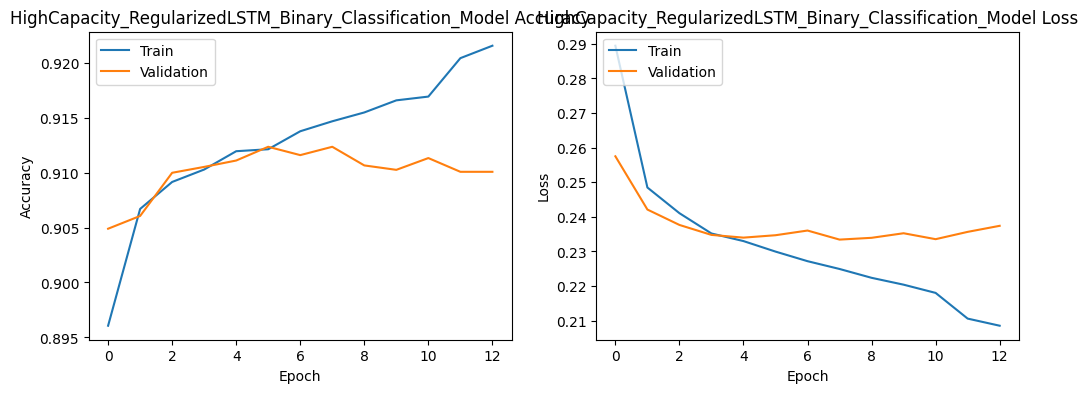

Plots saved as images/HighCapacity_RegularizedLSTM_Binary_Classification_Model_accuracy.png and images/HighCapacity_RegularizedLSTM_Binary_Classification_Model_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 12s 18ms/step
Accuracy: 0.9126
Precision: 0.6948
Recall: 0.3260
F1 Score: 0.4437
MCC Score: 0.4372
Balanced Accuracy: 0.6544


(0.912573673870334,
 0.6948398576512456,
 0.3259599332220367,
 0.44375,
 0.4371820763470581,
 0.6544049666110183)

700/700 [==============================] - 15s 21ms/step


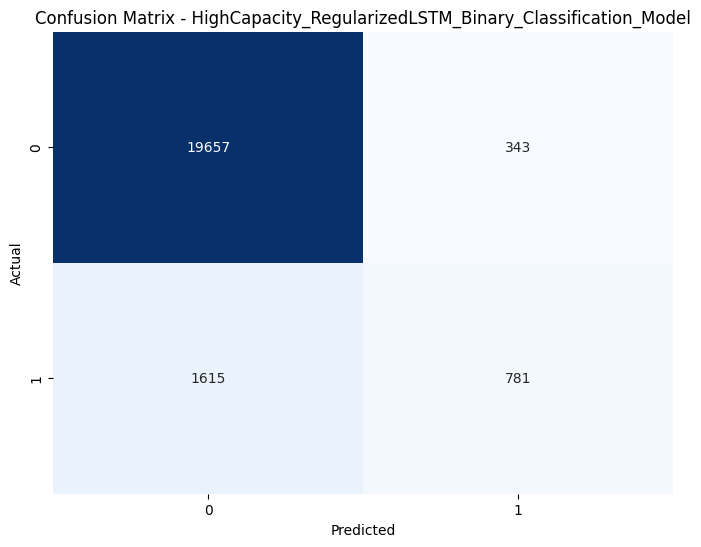

In [ ]:
# Generate predictions for the test set using the best model
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

### Simplified & Regularized LSTM Classifier

In [ ]:
# Define the model
model = Sequential()

# Adding a single LSTM layer with reduced units and dropout regularization
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))

# Adding a Dense layer for classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_score])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1050/1050 [==============================] - 10s 6ms/step - loss: 0.3050 - precision_m: 0.1069 - recall_m: 0.0214 - accuracy: 0.8934 - f1_score: 0.0330 - val_loss: 0.2695 - val_precision_m: 0.3529 - val_recall_m: 0.0648 - val_accuracy: 0.8977 - val_f1_score: 0.1058 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 7s 7ms/step - loss: 0.2579 - precision_m: 0.5414 - recall_m: 0.1731 - accuracy: 0.9038 - f1_score: 0.2482 - val_loss: 0.2516 - val_precision_m: 0.5137 - val_recall_m: 0.1401 - val_accuracy: 0.9012 - val_f1_score: 0.2077 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 7s 7ms/step - loss: 0.2473 - precision_m: 0.6166 - recall_m: 0.2408 - accuracy: 0.9071 - f1_score: 0.3248 - val_loss: 0.2456 - val_precision_m: 0.6223 - val_recall_m: 0.3219 - val_accuracy: 0.9099 - val_f1_score: 0.4027 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 8s 8ms/step - loss: 0.2426 - precision_m: 0.6242 - recall_m: 0.2652 - accura

In [ ]:
os.makedirs(MODELS_DIR, exist_ok=True)
model_name = "Simplified_Regularized_Binary_Classification_Model"
# save the model and its weights
model_path = os.path.join(MODELS_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODELS_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


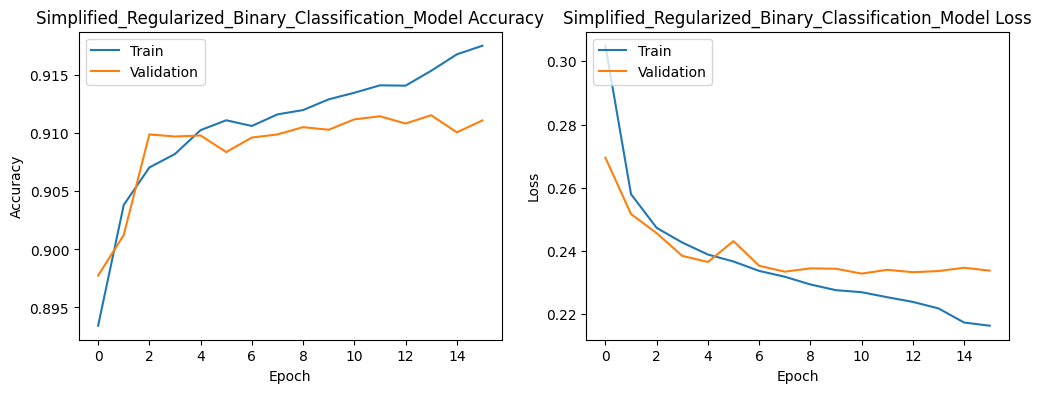

Plots saved as images/Simplified_Regularized_Binary_Classification_Model_accuracy.png and images/Simplified_Regularized_Binary_Classification_Model_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

# Use the function to print metrics for the test set
print_metrics(y_test, y_test_pred, 'Test Set')

700/700 [==============================] - 2s 2ms/step
Test Set Metrics:
Accuracy: 0.9112
Precision: 0.7161
Recall: 0.2821
F1 Score: 0.4048
------------------------------


### Simplified & More Regularized LSTM Classifier

In [ ]:
# Define the model
model = Sequential()

# Adding a single LSTM layer with reduced units and dropout regularization
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))

# Adding a Dense layer for classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_score])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1050/1050 [==============================] - 15s 9ms/step - loss: 0.3308 - precision_m: 0.0089 - recall_m: 0.0038 - accuracy: 0.8916 - f1_score: 0.0030 - val_loss: 0.2919 - val_precision_m: 0.0143 - val_recall_m: 0.0019 - val_accuracy: 0.8931 - val_f1_score: 0.0034 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 8s 8ms/step - loss: 0.2831 - precision_m: 0.2398 - recall_m: 0.0457 - accuracy: 0.8961 - f1_score: 0.0739 - val_loss: 0.2730 - val_precision_m: 0.4774 - val_recall_m: 0.1165 - val_accuracy: 0.9006 - val_f1_score: 0.1779 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 7s 6ms/step - loss: 0.2676 - precision_m: 0.5212 - recall_m: 0.1320 - accuracy: 0.9017 - f1_score: 0.2001 - val_loss: 0.2615 - val_precision_m: 0.4731 - val_recall_m: 0.1132 - val_accuracy: 0.9003 - val_f1_score: 0.1719 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 8s 8ms/step - loss: 0.2607 - precision_m: 0.5610 - recall_m: 0.1673 - accura

In [ ]:
os.makedirs(MODELS_DIR, exist_ok=True)
model_name = "Simplified_Regularized_Binary_Classification_Model"
# save the model and its weights
model_path = os.path.join(MODELS_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODELS_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


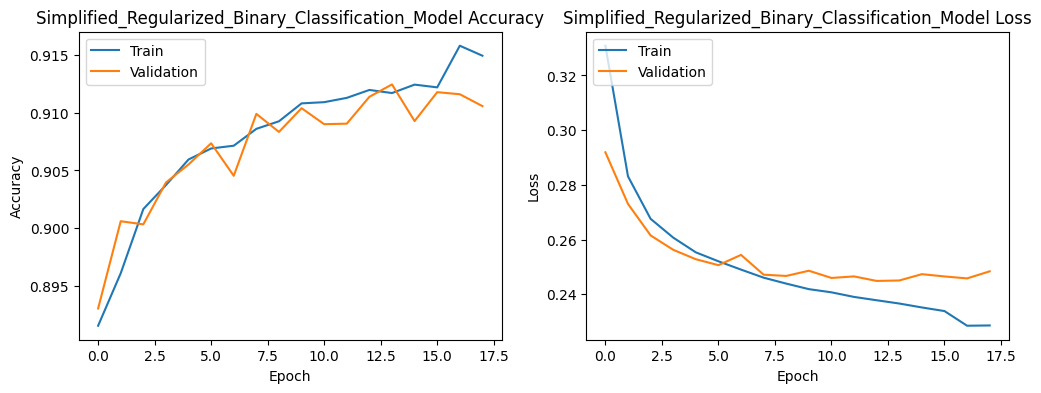

Plots saved as images/Simplified_Regularized_Binary_Classification_Model_accuracy.png and images/Simplified_Regularized_Binary_Classification_Model_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

# Use the function to print metrics for the test set
print_metrics(y_test, y_test_pred, 'Test Set')

700/700 [==============================] - 3s 3ms/step
Test Set Metrics:
Accuracy: 0.9120
Precision: 0.7196
Recall: 0.2913
F1 Score: 0.4147
------------------------------


## Comparison of Model Performance

### Evaluation Metrics

To assess the performance of the machine learning models in this project, several evaluation metrics are utilized:

#### F1 Score
The F1 score is the harmonic mean of precision and recall. It provides a balance between the two, making it useful for imbalanced datasets. It is calculated as:
\[ \text{F1 Score} = 2 \times \left( \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \right) \]

- **Precision**: The number of true positive results divided by the number of all positive results predicted by the model.
- **Recall**: The number of true positive results divided by the number of true positives plus the number of false negatives.

#### Matthews Correlation Coefficient (MCC)
The MCC is a measure of the quality of binary classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure even for imbalanced datasets. It is calculated as:
\[ \text{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}} \]

where:
- \(TP\): True Positives
- \(TN\): True Negatives
- \(FP\): False Positives
- \(FN\): False Negatives

#### Balanced Accuracy Score
Balanced accuracy is the average of recall obtained on each class. It is useful when dealing with imbalanced datasets as it gives each class equal weight. It is calculated as:

\[ \text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right) \]

#### Classification Report
A comprehensive report that includes precision, recall, F1 score, and support for each class, providing a detailed view of the model’s performance.

#### Calibration Curve
A calibration curve, or reliability diagram, plots the relationship between predicted probabilities and the actual outcomes. It is used to assess the calibration of probabilistic predictions.

#### Confusion Matrix
A confusion matrix is a summary of prediction results on a classification problem. It shows the number of true positives, true negatives, false positives, and false negatives, providing insight into the performance of the model.

These metrics collectively provide a comprehensive evaluation of the models, ensuring robust assessment and comparison to drive the project’s success in sequential classification and data-driven decision-making.


After thoroughly analyzing the loss and accuracy graphs and comparing performance metrics on the test set, we summarized our findings in the table below.

| Model                                                 | Threshold | Accuracy | Precision | Recall | F1 Score | MCC Score | Balanced Accuracy |
|-------------------------------------------------------|-----------|----------|-----------|--------|----------|-----------|-------------------|
| Baseline Performance (All Zeros)                      | -         | 0.8930   | 1.0000    | 0.0000 | 0.0000   | 0.0000    | 0.5000            |
| Deep LSTM Classifier With Duplicates                  | 0.5       | 0.9135   | 0.6383    | 0.3795 | 0.4760   | 0.4496    | 0.6773            |
| Deep LSTM Classifier Without Duplicates               | 0.5       | 0.9054   | 0.6900    | 0.3521 | 0.4662   | 0.4490    | 0.6655            |
| Deep LSTM Classifier                                  | 0.5       | 0.9190   | 0.7530    | 0.3614 | 0.4884   | 0.4863    | 0.6736            |
| F1 Optimized LSTM Classifier                          | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| MCC Optimized LSTM Classifier                         | 0.26      | 0.9025   | 0.5390    | 0.6144 | 0.5742   | 0.5209    | 0.7757            |
| Regularized Deep LSTM Classifier                      | 0.5       | 0.8977   | 0.6300    | 0.1052 | 0.1803   | 0.2282    | 0.5489            |
| F1 Optimized Regularized LSTM Classifier              | 0.2       | 0.8625   | 0.3902    | 0.5071 | 0.4410   | 0.3682    | 0.7061            |
| MCC Optimized Regularized LSTM Classifier             | 0.22      | 0.8724   | 0.4147    | 0.4674 | 0.4395   | 0.3686    | 0.6942            |
| Regularized Deep LSTM Classifier with Large Batch Size| 0.5       | 0.8968   | 0.6232    | 0.0897 | 0.1569   | 0.2089    | 0.5416            |
| F1 Optimized Regularized Deep LSTM Classifier with Large Batch Size | 0.17 | 0.8486 | 0.3651 | 0.5622 | 0.4427 | 0.3709 | 0.7225 |
| High-Capacity Deep LSTM Classifier                    | 0.5       | 0.9100   | 0.6631    | 0.3836 | 0.4860   | 0.4621    | 0.6801            |
| F1 Optimized High-Capacity Deep LSTM Classifier       | 0.28      | 0.8935   | 0.5019    | 0.5968 | 0.5453   | 0.4878    | 0.7629            |
| High-Capacity Regularized LSTM Classifier             | 0.5       | 0.8970   | 0.6233    | 0.0939 | 0.1632   | 0.2138    | 0.5436            |
| F1 Optimized High-Capacity Regularized LSTM Classifier| 0.2       | 0.8685   | 0.4040    | 0.4829 | 0.4399   | 0.3679    | 0.6988            |
| Simplified LSTM Classifier                            | 0.5       | 0.9126   | 0.6948    | 0.3260 | 0.4437   | 0.4372    | 0.6544            |
| Simplified & Regularized LSTM Classifier              | 0.5       | 0.9112   | 0.7161    | 0.2821 | 0.4048   | -         | -                 |
| Simplified & More Regularized LSTM Classifier         | 0.5       | 0.9120   | 0.7196    | 0.2913 | 0.4147   | -         | -                 |

In this study, we had one-hot encoded sequences of the last ten transactions for each customer at a bank, and our task is to predict whether a customer will buy a target product. Given the class imbalance (class 1 being 9-10 times smaller than class 0), it's crucial to consider both the predictive performance and the ability to handle this imbalance effectively. That is why we should choose a model that balances precision and recall well, as we need to identify potential buyers without overwhelming the system with too many false positives. To capture potential buyers as much as possible, we need to choose a model which maximizes recall, while keeping other metrics balanced. Thus, we have two candidates: F1 Optimized LSTM Classifier and F1 Optimized High-Capacity Deep LSTM Classifier. The first selection has the highest F1 score, MCC score, and balanced accuracy, indicating a good balance between precision and recall. The second choice also shows a good balance of precision and recall, but with a slightly lower F1 score and MCC score.

In a business scenario, the bank may run a marketing campaign to sell the target product to its customers and needs to predict in advance who will buy it. Assuming the revenue from selling the product to customers is greater than the cost of marketing to the wrong candidates, it is crucial to prioritize recall to ensure that as many potential buyers as possible are identified. Dwelling into the Recall Comparison table, we once again became sure of our selection of model.

| Model                                                 | Threshold | Recall |
|-------------------------------------------------------|-----------|--------|
| Baseline Performance (All Zeros)                      | -         | 0.0000 |
| Deep LSTM Classifier With Duplicates                  | 0.5       | 0.3795 |
| Deep LSTM Classifier Without Duplicates               | 0.5       | 0.3521 |
| Deep LSTM Classifier                                  | 0.5       | 0.3614 |
| F1 Optimized LSTM Classifier                          | 0.26      | 0.6144 |
| MCC Optimized LSTM Classifier                         | 0.26      | 0.6144 |
| Regularized Deep LSTM Classifier                      | 0.5       | 0.1052 |
| F1 Optimized Regularized LSTM Classifier              | 0.2       | 0.5071 |
| MCC Optimized Regularized LSTM Classifier             | 0.22      | 0.4674 |
| Regularized Deep LSTM Classifier with Large Batch Size| 0.5       | 0.0897 |
| F1 Optimized Regularized Deep LSTM Classifier with Large Batch Size | 0.17 | 0.5622 |
| High-Capacity Deep LSTM Classifier                    | 0.5       | 0.3836 |
| F1 Optimized High-Capacity Deep LSTM Classifier       | 0.28      | 0.5968 |
| High-Capacity Regularized LSTM Classifier             | 0.5       | 0.0939 |
| F1 Optimized High-Capacity Regularized LSTM Classifier| 0.2       | 0.4829 |
| Simplified LSTM Classifier                            | 0.5       | 0.3260 |
| Simplified & Regularized LSTM Classifier              | 0.5       | 0.2821 |
| Simplified & More Regularized LSTM Classifier         | 0.5       | 0.2913 |

## Addressing Class Imbalance

Class imbalance skews model training, resulting in high accuracy for the majority class but significantly low performance for the minority class, which may be of primary interest. Since we have a highly skewed data set, In this we explored techniques such as resampling, using appropriate evaluation metrics, and implementing algorithm-level adjustments help create a balanced dataset, improving the model's ability to generalize and perform accurately across all classes.

In [ ]:
# Construct the full path to the model file
model_name = "Binary_Classification_Model_with_LSTM"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Cost-sensitive Training

In our imbalanced dataset, the minority class, class 1, is underrepresented. This causes our models to be biased towards the majority class 0. Typically, machine learning models treat all types of errors equally and try to reduce the total number of errors. However,ut in real life, the cost of false positives and false negatives could be quite different. For our business case, the cost of losing a potential customer due to a wrong prediction is significantly higher than the cost of mistakenly labeling someone who will never buy the product as a potential candidate.

To address this issue, we implement cost-sensitive training. This involves assigning higher costs to errors involving the minority class, effectively penalizing the model more for these mistakes. By doing so, we ensure that our model pays more attention to the minority class, leading to better overall performance and a more balanced approach to error handling. This is crucial for our business as it helps us to better identify and retain potential customers, thereby improving our conversion rates and overall customer satisfaction.

In [ ]:
# Flatten y_train if it's not already a 1D array
y_train_flat = y_train.ravel()  # or y_train.flatten()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.5598916666666667, 1: 4.674203422846807}


In [ ]:
# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)


Epoch 1/50
1049/1050 [============================>.] - ETA: 0s - loss: 0.3889 - precision_m: 0.3356 - recall_m: 0.8483 - accuracy: 0.8027 - f1_m: 0.4701

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1050/1050 [==============================] - 50s 43ms/step - loss: 0.3891 - precision_m: 0.3358 - recall_m: 0.8484 - accuracy: 0.8027 - f1_m: 0.4703 - val_loss: 0.4099 - val_precision_m: 0.3196 - val_recall_m: 0.8350 - val_accuracy: 0.7917 - val_f1_m: 0.4526 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 40s 38ms/step - loss: 0.3851 - precision_m: 0.3380 - recall_m: 0.8471 - accuracy: 0.8048 - f1_m: 0.4724 - val_loss: 0.3752 - val_precision_m: 0.3558 - val_recall_m: 0.7505 - val_accuracy: 0.8282 - val_f1_m: 0.4721 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 40s 38ms/step - loss: 0.3790 - precision_m: 0.3421 - recall_m: 0.8583 - accuracy: 0.8065 - f1_m: 0.4784 - val_loss: 0.4070 - val_precision_m: 0.3299 - val_recall_m: 0.8143 - val_accuracy: 0.8037 - val_f1_m: 0.4599 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 41s 39ms/step - loss: 0.3758 - precision_m: 0.3452 - recall_m: 0.8598 - accuracy: 0.8096 - f1_m: 0.4816 - 

In [ ]:
# Construct the full path to the model file
model_name = "Weighted_Binary_Classification_LSTM_Model"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Weighted_Binary_Classification_LSTM_Model indicate that while the model achieves a high overall accuracy of 91.70%, the performance metrics for the minority class (as indicated by precision, recall, F1 score, and MCC) suggest room for improvement. The precision of 71.71% indicates that when the model predicts a positive instance, it is correct 71.71% of the time, which is reasonable. However, the recall of 37.02% is low, showing that the model only identifies 37.02% of all actual positive instances, indicating it misses a significant portion of the minority class. The F1 score, which balances precision and recall, is 48.83%, reflecting the trade-off between these metrics and highlighting the model's struggle to fully capture the minority class. The MCC score of 47.72%, a measure of the quality of binary classifications, suggests moderate performance but also indicates that the model's predictions are not highly reliable, especially for the minority class.

In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 11s 14ms/step
Accuracy: 0.9170
Precision: 0.7171
Recall: 0.3702
F1 Score: 0.4883
MCC Score: 0.4772
Balanced Accuracy: 0.6764


(0.9169941060903732,
 0.7170573969280517,
 0.3702003338898164,
 0.48830167905312416,
 0.4772345268776241,
 0.6763501669449082)

The curves suggest that the model is well-trained on the training data but shows signs of overfitting as the validation accuracy does not improve substantially and the validation loss increases after a few epochs.

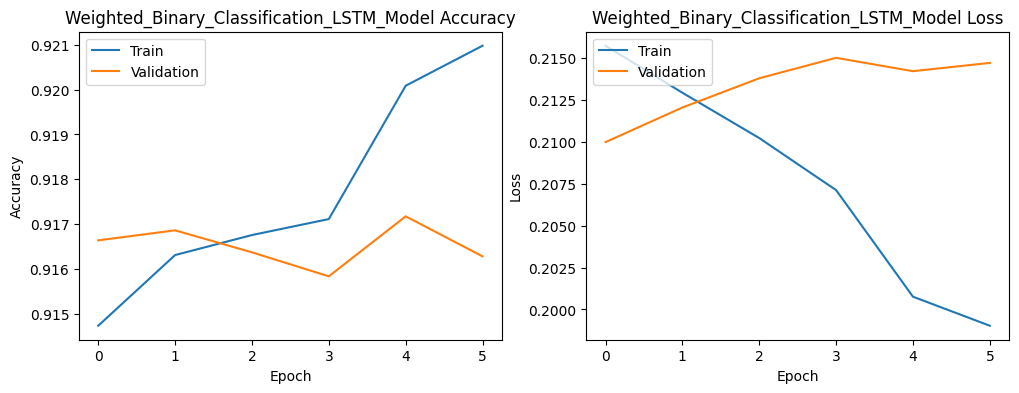

Plots saved as images/Weighted_Binary_Classification_LSTM_Model_accuracy.png and images/Weighted_Binary_Classification_LSTM_Model_loss.png


In [ ]:
# Load history from pickle
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'rb') as file:
    history_dict = pickle.load(file)

# Create a mock object to hold the history dictionary
class History:
    def __init__(self, history_dict):
        self.history = history_dict

# Convert dictionary to History object
history = History(history_dict)

# Plot the training history
plot_and_save_training_history(history, model_name, save_dir='images')

As seen from the confusion matrix below, the model has difficulty correctly identifying the minority class.

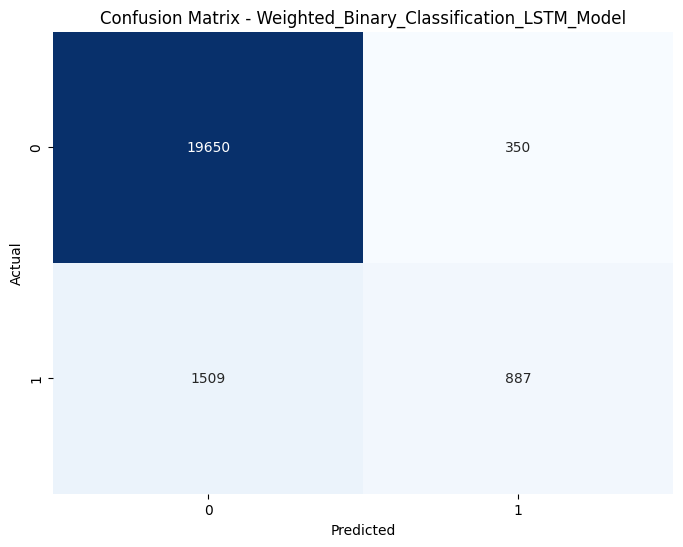

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

The model's predictions is relatively close to the perfect calibration. This indicates that the model is well-calibrated. Model's probability estimates are reliable and reflect the true likelihood of positive outcomes.

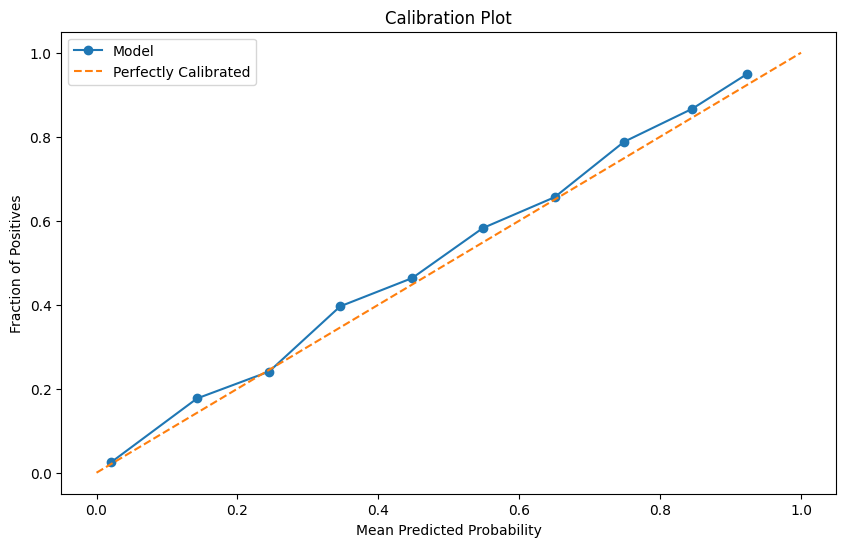

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

##### Threshold Adjustment

After adjusting the threshold to 0.3, the performance metrics of the model show significant improvements, particularly in handling class imbalance. The overall accuracy remains high at 91.02%, indicating that the model still performs well on the majority of the data. The balanced accuracy has increased to 75.19%, reflecting better performance across both classes. Precision is now at 58.54%, suggesting that the model's positive predictions are more accurate. Importantly, the recall has improved to 55.05%, meaning the model is better at identifying true positive instances. The F1 score, which balances precision and recall, has risen to 56.74%, indicating overall enhanced performance on the minority class. The Matthews Correlation Coefficient (MCC) has increased to 51.77%, signifying a better balance between true and false positives and negatives. These improvements suggest that threshold adjustment has made the model more effective in recognizing the minority class without significantly compromising overall accuracy.

Best Threshold: 0.3
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.9102
Balanced Accuracy: 0.7519
Precision: 0.5854
Recall: 0.5505
F1 Score: 0.5674
MCC: 0.5177


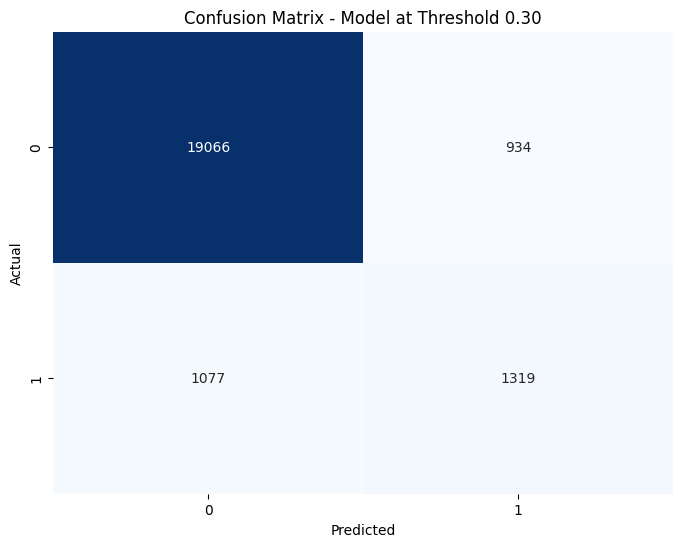

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

#### Cost Sensitive Training: Recall Optimized

The MCC-optimized, cost-sensitive training strategy aims to maximize the Matthews Correlation Coefficient (MCC), a balanced metric that considers true and false positives and negatives, providing a comprehensive measure of model performance. A grid of class weights is created, with the weight for the positive class varying while keeping the negative class weight constant. GridSearchCV is then used to find the optimal class weight that maximizes the MCC. The best class weight is utilized to train the final model, which is saved along with its training history for future reference. This method ensures that the model maintains a balanced performance across both classes, effectively addressing the cost of misclassifications and improving the overall reliability of the model in handling imbalanced datasets.

In [ ]:
# Define the grid of class weights
class_weight_grid = [{0: 1, 1: weight} for weight in range(1, 11)]

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_name = 'Weight_Optimized_Deep_LSTM_Model'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Define the scoring metric (recall in this case)
scoring = make_scorer(recall_score, pos_label=1)

# Perform grid search
param_grid = {'class_weight': class_weight_grid}
grid = GridSearchCV(estimator=KerasGridSearch(epochs=50, batch_size=64), param_grid=param_grid, cv=3, scoring=scoring)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val),
                       callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Print the best weight
best_class_weight = grid_result.best_params_['class_weight']
print("Best class weight:", best_class_weight)

# Train the model with the best class weight
best_model = grid_result.best_estimator_
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
best_model.model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(best_model.history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in best_model.history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)


Epoch 1/50
699/700 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8940 - precision_m: 0.1609 - recall_m: 0.0396 - f1_m: 0.0589

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/700 [==============================] - 29s 36ms/step - loss: 0.2978 - accuracy: 0.8940 - precision_m: 0.1621 - recall_m: 0.0398 - f1_m: 0.0593 - val_loss: 0.2412 - val_accuracy: 0.9015 - val_precision_m: 0.5561 - val_recall_m: 0.1726 - val_f1_m: 0.2468 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 24s 34ms/step - loss: 0.2372 - accuracy: 0.9050 - precision_m: 0.5886 - recall_m: 0.2453 - f1_m: 0.3241 - val_loss: 0.2301 - val_accuracy: 0.9093 - val_precision_m: 0.6610 - val_recall_m: 0.2655 - val_f1_m: 0.3561 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 24s 34ms/step - loss: 0.2300 - accuracy: 0.9086 - precision_m: 0.6162 - recall_m: 0.2996 - f1_m: 0.3787 - val_loss: 0.2269 - val_accuracy: 0.9093 - val_precision_m: 0.6545 - val_recall_m: 0.2790 - val_f1_m: 0.3695 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 22s 31ms/step - loss: 0.2251 - accuracy: 0.9116 - precision_m: 0.6611 - recall_m: 0.3292 - f1_m: 0.4140 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/700 [==============================] - 22s 31ms/step - loss: 0.2213 - accuracy: 0.9115 - precision_m: 0.6570 - recall_m: 0.3381 - f1_m: 0.4213 - val_loss: 0.2253 - val_accuracy: 0.9101 - val_precision_m: 0.6408 - val_recall_m: 0.3311 - val_f1_m: 0.4152 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 23s 33ms/step - loss: 0.2185 - accuracy: 0.9130 - precision_m: 0.6537 - recall_m: 0.3506 - f1_m: 0.4317 - val_loss: 0.2264 - val_accuracy: 0.9110 - val_precision_m: 0.6520 - val_recall_m: 0.3204 - val_f1_m: 0.4072 - lr: 0.0010
Epoch 8/50
700/700 [==============================] - 21s 30ms/step - loss: 0.2167 - accuracy: 0.9141 - precision_m: 0.6881 - recall_m: 0.3661 - f1_m: 0.4500 - val_loss: 0.2239 - val_accuracy: 0.9129 - val_precision_m: 0.6687 - val_recall_m: 0.3237 - val_f1_m: 0.4130 - lr: 0.0010
Epoch 9/50
700/700 [==============================] - 23s 33ms/step - loss: 0.2142 - accuracy: 0.9134 - precision_m: 0.6696 - recall_m: 0.3665 - f1_m: 0.4457 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/700 [==============================] - 23s 33ms/step - loss: 0.2152 - accuracy: 0.9152 - precision_m: 0.6754 - recall_m: 0.3710 - f1_m: 0.4532 - val_loss: 0.2239 - val_accuracy: 0.9127 - val_precision_m: 0.6487 - val_recall_m: 0.3653 - val_f1_m: 0.4464 - lr: 0.0010
Epoch 9/50
700/700 [==============================] - 22s 32ms/step - loss: 0.2137 - accuracy: 0.9159 - precision_m: 0.6778 - recall_m: 0.3775 - f1_m: 0.4603 - val_loss: 0.2249 - val_accuracy: 0.9117 - val_precision_m: 0.6322 - val_recall_m: 0.3778 - val_f1_m: 0.4512 - lr: 0.0010
Epoch 10/50
700/700 [==============================] - 23s 33ms/step - loss: 0.2116 - accuracy: 0.9170 - precision_m: 0.6824 - recall_m: 0.3808 - f1_m: 0.4625 - val_loss: 0.2260 - val_accuracy: 0.9130 - val_precision_m: 0.6591 - val_recall_m: 0.3719 - val_f1_m: 0.4512 - lr: 0.0010
Epoch 11/50
700/700 [==============================] - 25s 36ms/step - loss: 0.2090 - accuracy: 0.9179 - precision_m: 0.6969 - recall_m: 0.4008 - f1_m: 0.4831 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model demonstrates strong performance with an accuracy of 79.88% and a balanced accuracy of 80.69%, indicating it handles class imbalance well. The high recall of 81.72% shows it's effective at identifying positive instances, though the lower precision of 32.49% suggests many false positives. The F1 score of 46.50% balances precision and recall, indicating moderate overall performance. The MCC score of 0.4278 reflects a moderate correlation between predictions and actual outcomes, suggesting room for improvement in precision.

In [ ]:
evaluate_model(best_model, X_test, y_test)

700/700 [==============================] - 13s 13ms/step
Accuracy: 0.7988
Precision: 0.3249
Recall: 0.8172
F1 Score: 0.4650
MCC Score: 0.4278
Balanced Accuracy: 0.8069


(0.798803357742454,
 0.3249253235977431,
 0.8171953255425709,
 0.4649726905723106,
 0.42780226339433514,
 0.8068976627712854)

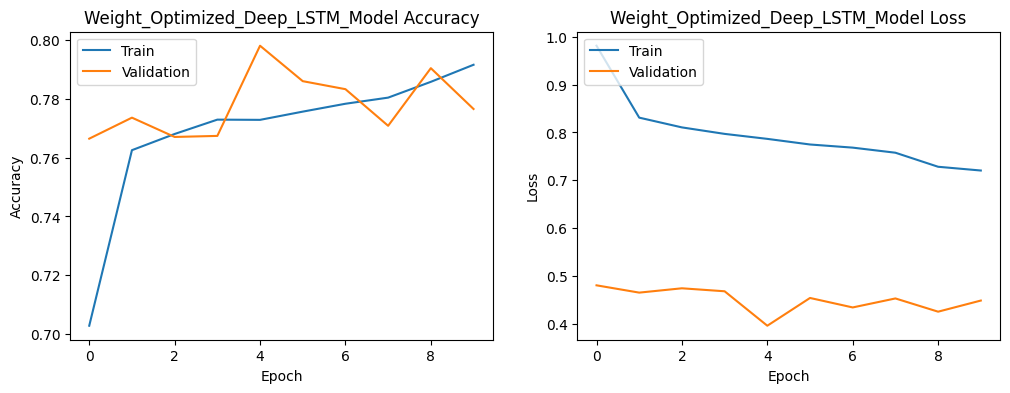

Plots saved as images/Weight_Optimized_Deep_LSTM_Model_accuracy.png and images/Weight_Optimized_Deep_LSTM_Model_loss.png


In [ ]:
# Construct the full path to the model file
model_name = "Weight_Optimized_Deep_LSTM_Model"

# Load history from pickle
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'rb') as file:
    history_dict = pickle.load(file)

# Create a mock object to hold the history dictionary
class History:
    def __init__(self, history_dict):
        self.history = history_dict

# Convert dictionary to History object
history = History(history_dict)

# Plot the training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
# Construct the full path to the model file
model_name = "Weight_Optimized_Deep_LSTM_Model"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
model.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_184 (LSTM)             (None, 10, 64)            96512     
                                                                 
 dropout_184 (Dropout)       (None, 10, 64)            0         
                                                                 
 lstm_185 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_185 (Dropout)       (None, 64)                0         
                                                                 
 dense_92 (Dense)            (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


700/700 [==============================] - 7s 8ms/step


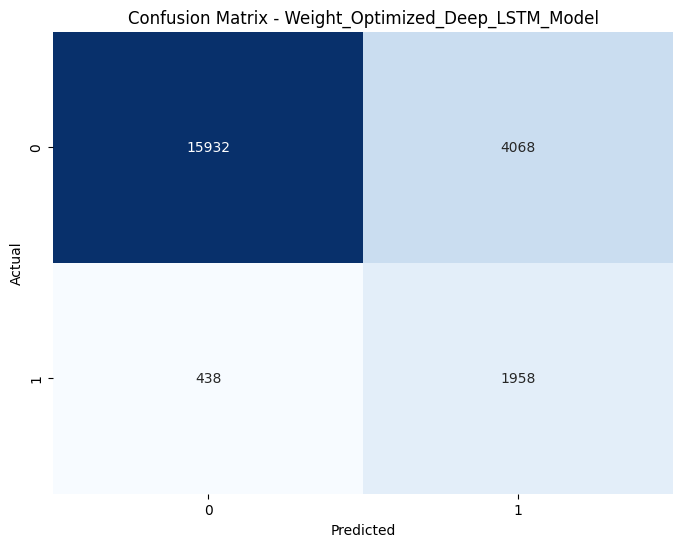

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

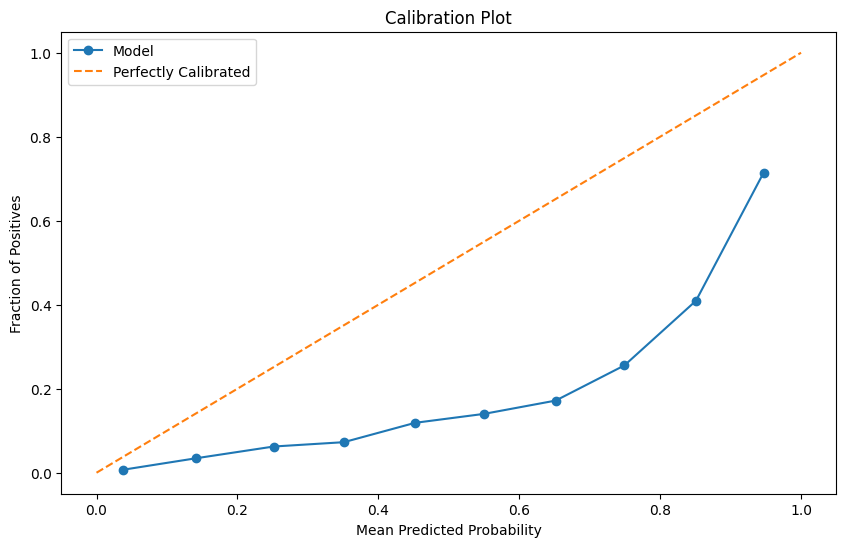

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

##### Threshold Adjustment

Best Threshold: 0.75
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.8936
Balanced Accuracy: 0.7623
Precision: 0.5023
Recall: 0.5952
F1 Score: 0.5448
MCC: 0.4873


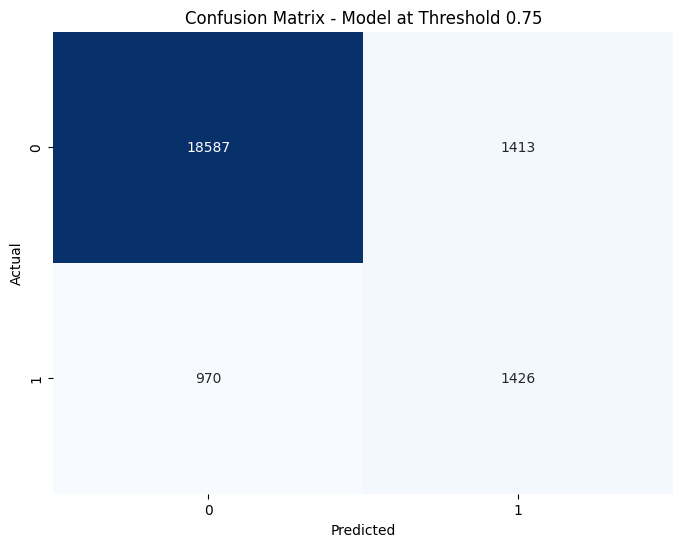

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

#### MCC-Optimized Cost-Sensitive Training

The MCC-optimized, cost-sensitive training strategy aims to maximize the Matthews Correlation Coefficient (MCC), a balanced metric that considers true and false positives and negatives, providing a comprehensive measure of model performance. A grid of class weights is created, with the weight for the positive class varying while keeping the negative class weight constant. GridSearchCV is then used to find the optimal class weight that maximizes the MCC. The best class weight is utilized to train the final model, which is saved along with its training history for future reference. This method ensures that the model maintains a balanced performance across both classes, effectively addressing the cost of misclassifications and improving the overall reliability of the model in handling imbalanced datasets.

In [ ]:
# Define the grid of class weights
class_weight_grid = [{0: 1, 1: weight} for weight in range(1, 11)]

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_name = 'MCC_Optimized_Weighted_Deep_LSTM_Model'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Define the scoring metric (MCC in this case)
scoring = make_scorer(matthews_corrcoef)

# Perform grid search
param_grid = {'class_weight': class_weight_grid}
grid = GridSearchCV(estimator=KerasGridSearch(epochs=50, batch_size=64), param_grid=param_grid, cv=3, scoring=scoring)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val),
                       callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Print the best weight
best_class_weight = grid_result.best_params_['class_weight']
print("Best class weight:", best_class_weight)

# Train the model with the best class weight
best_model = grid_result.best_estimator_
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
best_model.model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(best_model.history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in best_model.history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)


Epoch 1/50
700/700 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8936 - precision_m: 0.1706 - recall_m: 0.0441 - f1_m: 0.0650 - mcc_m: 0.0721

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/700 [==============================] - 48s 62ms/step - loss: 0.2916 - accuracy: 0.8936 - precision_m: 0.1706 - recall_m: 0.0441 - f1_m: 0.0650 - mcc_m: 0.0721 - val_loss: 0.2388 - val_accuracy: 0.9029 - val_precision_m: 0.5873 - val_recall_m: 0.2049 - val_f1_m: 0.2842 - val_mcc_m: 0.3007 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 33s 47ms/step - loss: 0.2361 - accuracy: 0.9061 - precision_m: 0.6057 - recall_m: 0.2674 - f1_m: 0.3496 - mcc_m: 0.3527 - val_loss: 0.2389 - val_accuracy: 0.9044 - val_precision_m: 0.5842 - val_recall_m: 0.1725 - val_f1_m: 0.2505 - val_mcc_m: 0.2804 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 31s 45ms/step - loss: 0.2283 - accuracy: 0.9102 - precision_m: 0.6597 - recall_m: 0.3127 - f1_m: 0.3980 - mcc_m: 0.4018 - val_loss: 0.2301 - val_accuracy: 0.9090 - val_precision_m: 0.6182 - val_recall_m: 0.3821 - val_f1_m: 0.4453 - val_mcc_m: 0.4286 - lr: 0.0010
Epoch 4/50
700/700 [==============================] - 23s 33

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/700 [==============================] - 25s 36ms/step - loss: 0.2221 - accuracy: 0.9111 - precision_m: 0.6393 - recall_m: 0.3253 - f1_m: 0.4079 - mcc_m: 0.4045 - val_loss: 0.2250 - val_accuracy: 0.9107 - val_precision_m: 0.6263 - val_recall_m: 0.3792 - val_f1_m: 0.4511 - val_mcc_m: 0.4343 - lr: 0.0010
Epoch 6/50
700/700 [==============================] - 25s 36ms/step - loss: 0.2209 - accuracy: 0.9106 - precision_m: 0.6324 - recall_m: 0.3427 - f1_m: 0.4190 - mcc_m: 0.4122 - val_loss: 0.2231 - val_accuracy: 0.9115 - val_precision_m: 0.6599 - val_recall_m: 0.3279 - val_f1_m: 0.4143 - val_mcc_m: 0.4137 - lr: 0.0010
Epoch 7/50
700/700 [==============================] - 24s 34ms/step - loss: 0.2175 - accuracy: 0.9142 - precision_m: 0.6723 - recall_m: 0.3643 - f1_m: 0.4468 - mcc_m: 0.4429 - val_loss: 0.2248 - val_accuracy: 0.9123 - val_precision_m: 0.6615 - val_recall_m: 0.3469 - val_f1_m: 0.4302 - val_mcc_m: 0.4265 - lr: 0.0010
Epoch 8/50
700/700 [==============================] - 25s 36

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Construct the full path to the model file
model_name = "MCC_Optimized_Weighted_Deep_LSTM_Model"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")

# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score, 'mcc_m': mcc_m})
# Verify the model architecture
model.summary()

Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_256 (LSTM)             (None, 10, 64)            96512     
                                                                 
 dropout_256 (Dropout)       (None, 10, 64)            0         
                                                                 
 lstm_257 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_257 (Dropout)       (None, 64)                0         
                                                                 
 dense_128 (Dense)           (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 9s 11ms/step
Accuracy: 0.8759
Precision: 0.4456
Recall: 0.6569
F1 Score: 0.5310
MCC Score: 0.4741
Balanced Accuracy: 0.7795


(0.8758706911948563,
 0.4456398640996603,
 0.6569282136894825,
 0.5310391363022942,
 0.47409447075804034,
 0.7795141068447413)

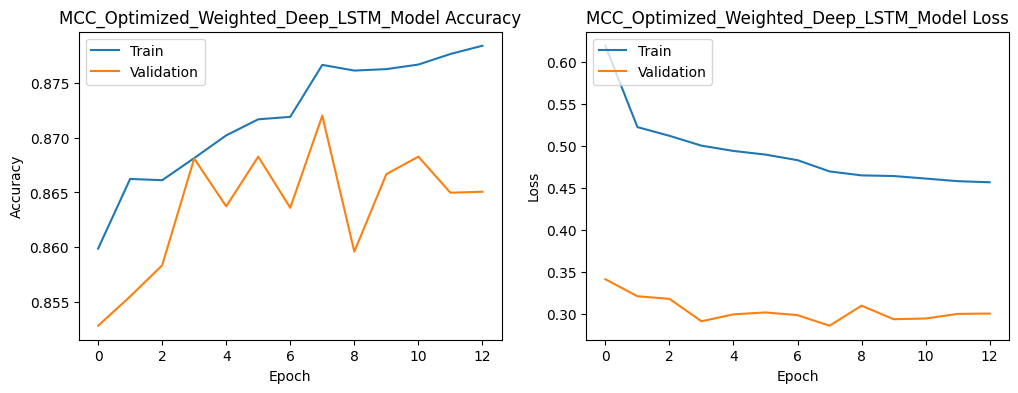

Plots saved as images/MCC_Optimized_Weighted_Deep_LSTM_Model_accuracy.png and images/MCC_Optimized_Weighted_Deep_LSTM_Model_loss.png


In [ ]:
# Load history from pickle
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'rb') as file:
    history_dict = pickle.load(file)

# Create a mock object to hold the history dictionary
class History:
    def __init__(self, history_dict):
        self.history = history_dict

# Convert dictionary to History object
history = History(history_dict)

# Plot the training history
plot_and_save_training_history(history, model_name, save_dir='images')

700/700 [==============================] - 6s 9ms/step


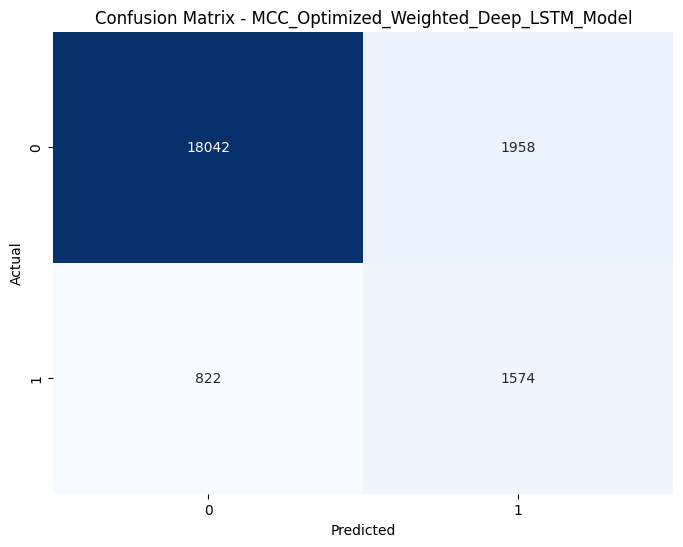

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

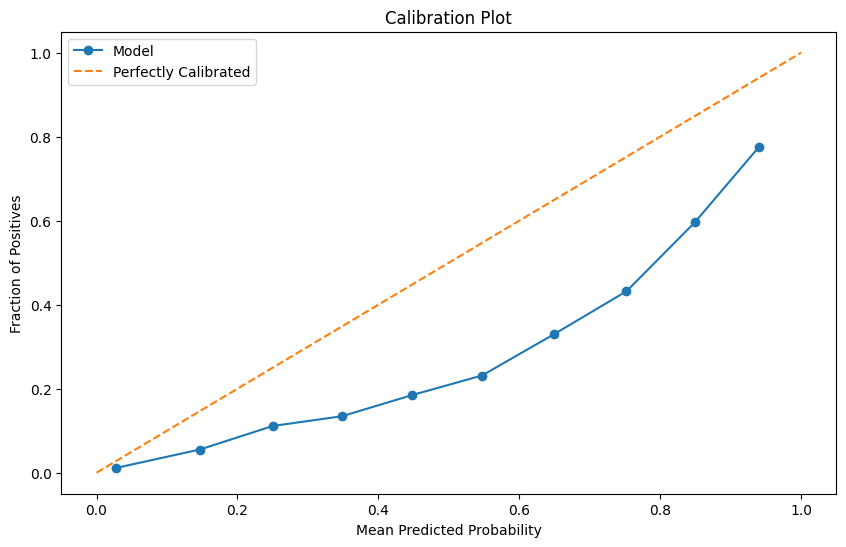

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

##### Threshold Adjustment

Best Threshold: 0.59
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.8961
Balanced Accuracy: 0.7589
Precision: 0.5128
Recall: 0.5843
F1 Score: 0.5462
MCC: 0.4892


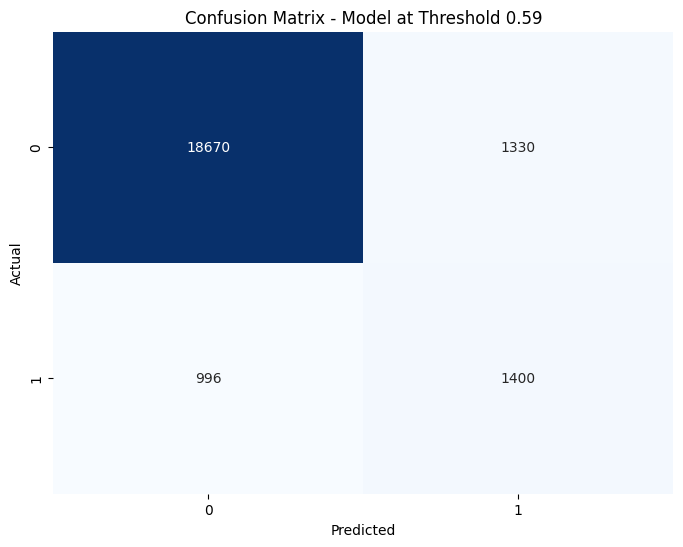

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

#### Over Sampling of Minority Class

SMOTE (Synthetic Minority Over-sampling Technique) helps fight class imbalance by generating synthetic samples for the minority class. It works by identifying minority class samples and creating new, synthetic samples by interpolating between these samples and their nearest neighbors. This results in a more balanced dataset, improving the model's ability to learn from and predict minority class instances.

To prevent data leakage. over sampling is carried on only training data.

In [ ]:
print(X_train.shape, y_train.shape)

(67187, 10, 312) (67187, 1)


In [ ]:
# Reshape the data to 2D
num_samples, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, num_timesteps * num_features)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_reshaped,y_train)

# Reshape data back to 3D
X_train_res = X_train_res.reshape(-1, num_timesteps, num_features)

In [ ]:
print(X_train_res.shape, y_train_res.shape)

(120000, 10, 312) (120000,)


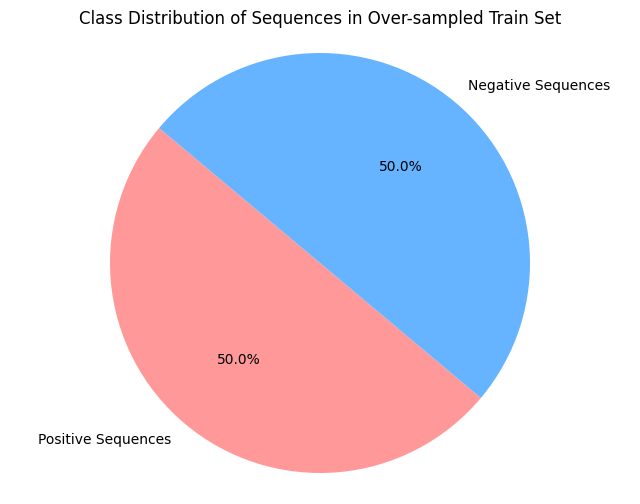

In [ ]:
plot_class_distribution(y_train_res, set_name='Over-sampled Train Set')

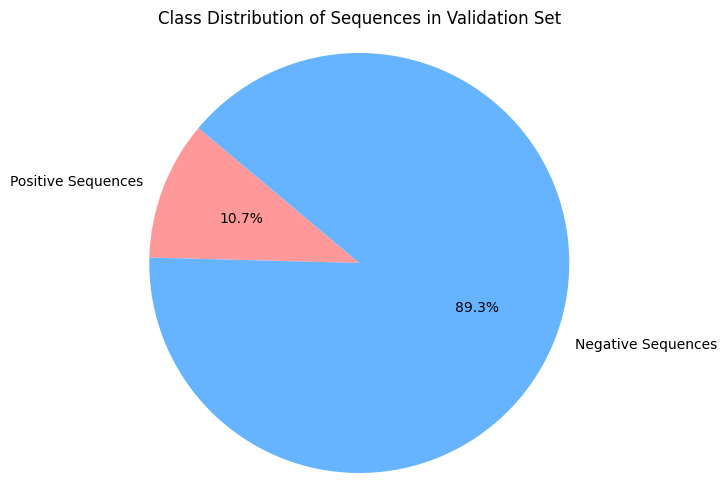

In [ ]:
plot_class_distribution(y_val, set_name='Validation Set')

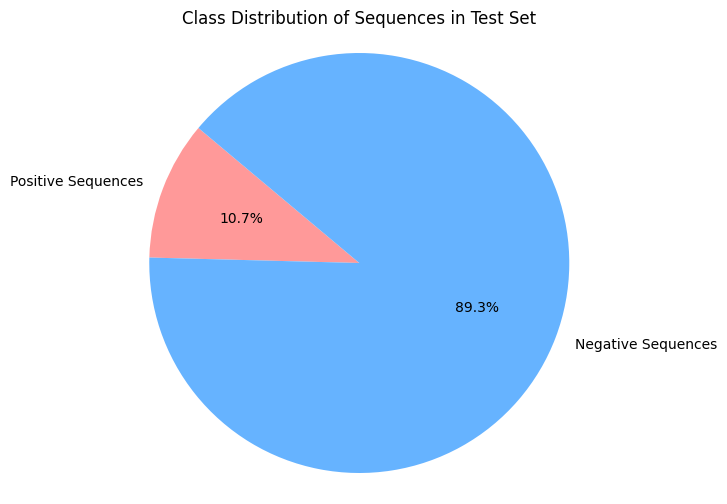

In [ ]:
plot_class_distribution(y_test, set_name='Test Set')

In [ ]:
# Construct the full path to the model file
model_name = "Binary_Classification_Model_with_LSTM"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_name = 'SMOTE_Oversampled_Binary_Classification_LSTM_Model'

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train_res, y_train_res, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1875/1875 [==============================] - ETA: 0s - loss: 0.1658 - precision_m: 0.9737 - recall_m: 0.8977 - accuracy: 0.9369 - f1_m: 0.9326

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 67s 34ms/step - loss: 0.1658 - precision_m: 0.9737 - recall_m: 0.8977 - accuracy: 0.9369 - f1_m: 0.9326 - val_loss: 0.2187 - val_precision_m: 0.6882 - val_recall_m: 0.3120 - val_accuracy: 0.9136 - val_f1_m: 0.4062 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1338 - precision_m: 0.9768 - recall_m: 0.9159 - accuracy: 0.9470 - f1_m: 0.9444 - val_loss: 0.2168 - val_precision_m: 0.6653 - val_recall_m: 0.3933 - val_accuracy: 0.9148 - val_f1_m: 0.4709 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1297 - precision_m: 0.9762 - recall_m: 0.9192 - accuracy: 0.9484 - f1_m: 0.9459 - val_loss: 0.2216 - val_precision_m: 0.6631 - val_recall_m: 0.3795 - val_accuracy: 0.9138 - val_f1_m: 0.4589 - lr: 0.0010
Epoch 4/50
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1273 - precision_m: 0.9771 - recall_m: 0.9209 - accuracy: 0.9495 - f1_m: 0.9473 - 

In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 9s 12ms/step
Accuracy: 0.9157
Precision: 0.6899
Recall: 0.3844
F1 Score: 0.4937
MCC Score: 0.4748
Balanced Accuracy: 0.6818


(0.9156545811752098,
 0.6898876404494382,
 0.3843906510851419,
 0.4937014205306888,
 0.4747996773295368,
 0.6818453255425709)

Signs of overfitting are evident in the loss and accuracy history graphs of the model trained with oversampling. This is reflected in the plateau observed in the validation set's performance metrics, suggesting that the model's generalization ability may have been compromised.

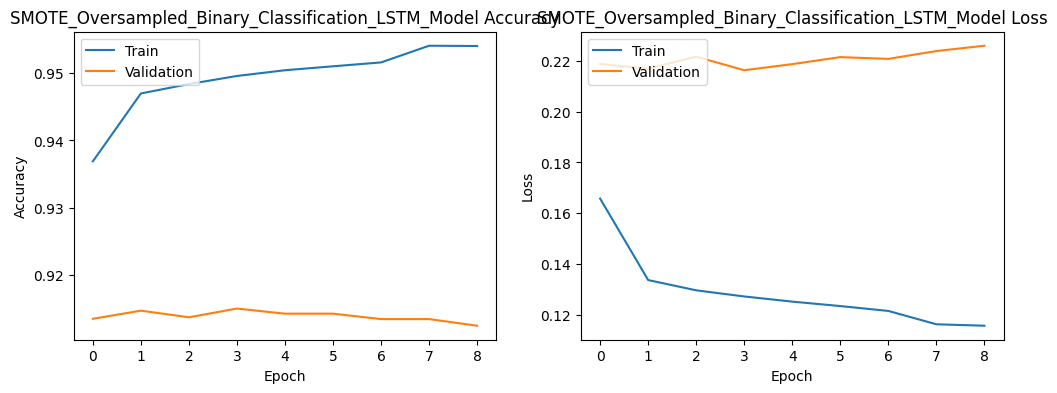

Plots saved as images/SMOTE_Oversampled_Binary_Classification_LSTM_Model_accuracy.png and images/SMOTE_Oversampled_Binary_Classification_LSTM_Model_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

The model trained with oversampling shows slightly lower precision and higher recall compared to the model trained on the highly imbalanced dataset. This indicates that the oversampling approach has helped improve the model's ability to correctly identify instances of the minority class (higher recall), albeit with a trade-off in precision.

While oversampling has improved the model's performance in terms of recall, the presence of overfitting is a concern. Overfitting can lead to poor generalization on unseen data, reducing the model's reliability in real-world scenarios.

700/700 [==============================] - 11s 16ms/step


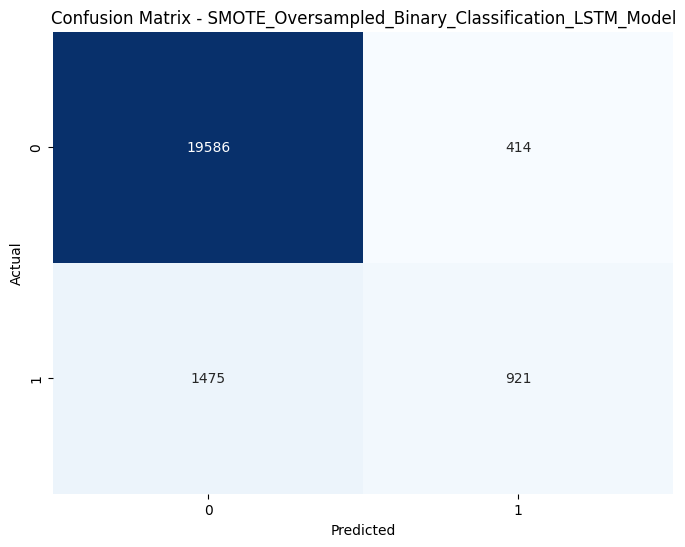

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

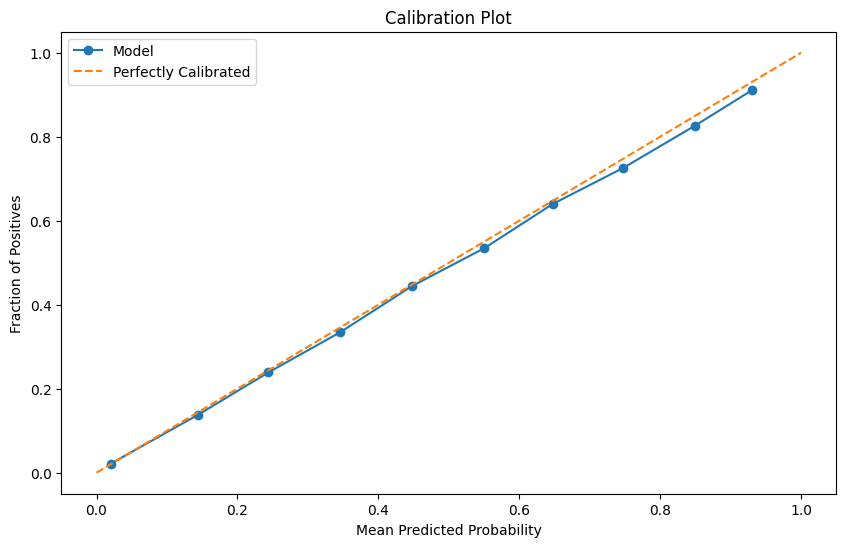

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

##### Threshold Adjustment

Best Threshold: 0.28
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.9004
Balanced Accuracy: 0.7624
Precision: 0.5312
Recall: 0.5868
F1 Score: 0.5576
MCC: 0.5024


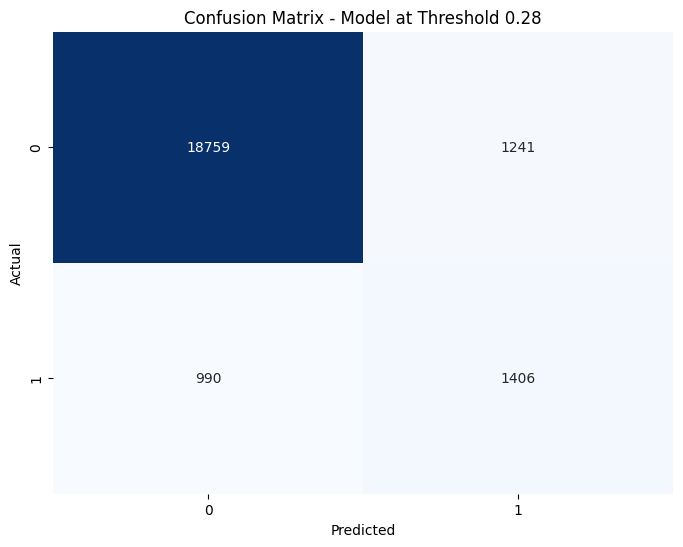

In [ ]:
# Find the best threshold (as done previously)
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_test, y_test_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

While oversampling has shown promise in improving the model's ability to detect minority class instances, addressing the observed overfitting is essential to ensure the model's reliability and generalization on unseen data.

#### Under Sampling of Majority Class

In [ ]:
# Reshape the data to 2D
num_samples, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, num_timesteps * num_features)

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_reshaped, y_train)

# Reshape data back to 3D
X_train_res = X_train_res.reshape(-1, num_timesteps, num_features)


In [ ]:
X_train.shape

(67187, 10, 312)

In [ ]:
X_train_res.shape

(14374, 10, 312)

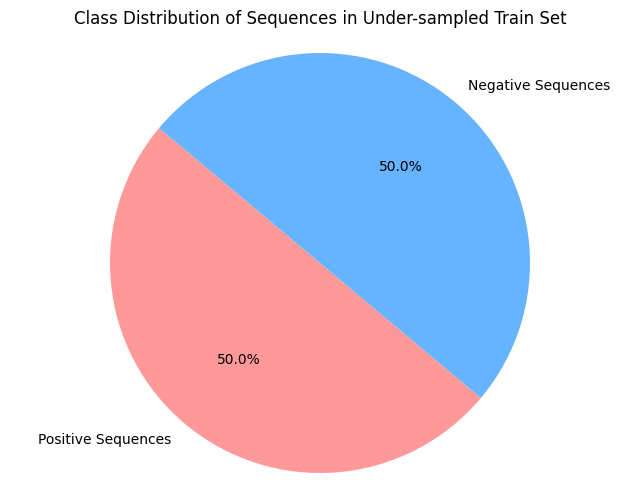

In [ ]:
plot_class_distribution(y_train_res, set_name='Under-sampled Train Set')

In [ ]:
# Construct the full path to the model file
model_name = "Binary_Classification_Model_with_LSTM"
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
# Load the saved model
model = load_model(model_path, custom_objects={'precision_m': precision_m,
                                               'recall_m': recall_m,
                                               'f1_m': f1_score})
# Verify the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            96512     
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 129601 (506.25 KB)
Trainable params: 129601 (506.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_name = 'Random_Undersampled_Deep_LSTM_Model'

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train_res, y_train_res, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
223/225 [============================>.] - ETA: 0s - loss: 0.4144 - precision_m: 0.8022 - recall_m: 0.8202 - accuracy: 0.8077 - f1_m: 0.8044

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 19s 62ms/step - loss: 0.4140 - precision_m: 0.8030 - recall_m: 0.8204 - accuracy: 0.8080 - f1_m: 0.8049 - val_loss: 0.4082 - val_precision_m: 0.3120 - val_recall_m: 0.8713 - val_accuracy: 0.7813 - val_f1_m: 0.4509 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - 13s 58ms/step - loss: 0.3930 - precision_m: 0.8065 - recall_m: 0.8493 - accuracy: 0.8224 - f1_m: 0.8250 - val_loss: 0.3655 - val_precision_m: 0.3477 - val_recall_m: 0.8273 - val_accuracy: 0.8154 - val_f1_m: 0.4793 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - 12s 54ms/step - loss: 0.3877 - precision_m: 0.8112 - recall_m: 0.8486 - accuracy: 0.8252 - f1_m: 0.8274 - val_loss: 0.3604 - val_precision_m: 0.3538 - val_recall_m: 0.8147 - val_accuracy: 0.8210 - val_f1_m: 0.4826 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - 10s 46ms/step - loss: 0.3813 - precision_m: 0.8119 - recall_m: 0.8550 - accuracy: 0.8291 - f1_m: 0.8308 - val_loss

In [ ]:
evaluate_model(model, X_test, y_test)

700/700 [==============================] - 8s 10ms/step
Accuracy: 0.8283
Precision: 0.3645
Recall: 0.8143
F1 Score: 0.5036
MCC Score: 0.4669
Balanced Accuracy: 0.8221


(0.8282729058760493,
 0.36453662182361735,
 0.8142737896494157,
 0.503613835828601,
 0.4669295374442457,
 0.8221118948247078)

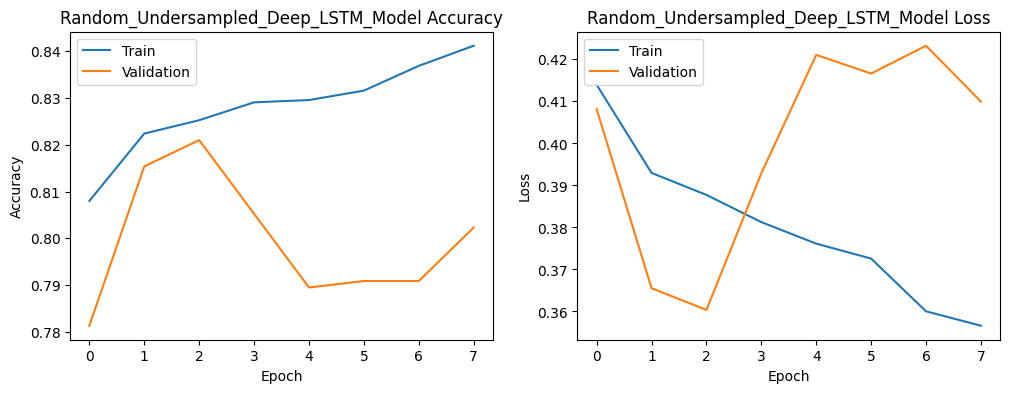

Plots saved as images/Random_Undersampled_Deep_LSTM_Model_accuracy.png and images/Random_Undersampled_Deep_LSTM_Model_loss.png


In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

Undersampling appears to have improved the model's ability to correctly identify instances of the minority class (higher recall) at the expense of overall accuracy.
The undersampled model achieves a better balance between precision and recall compared to the imbalanced dataset model.
However, compared to oversampling, undersampling seems to sacrifice overall accuracy and precision for higher recall.

700/700 [==============================] - 5s 7ms/step


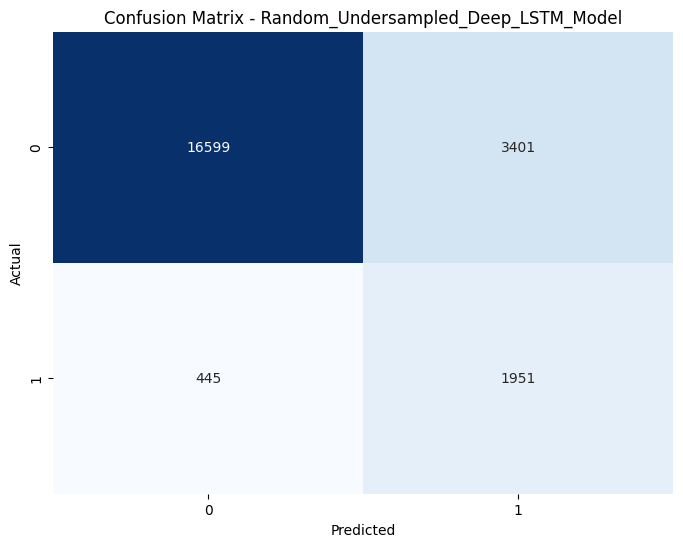

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

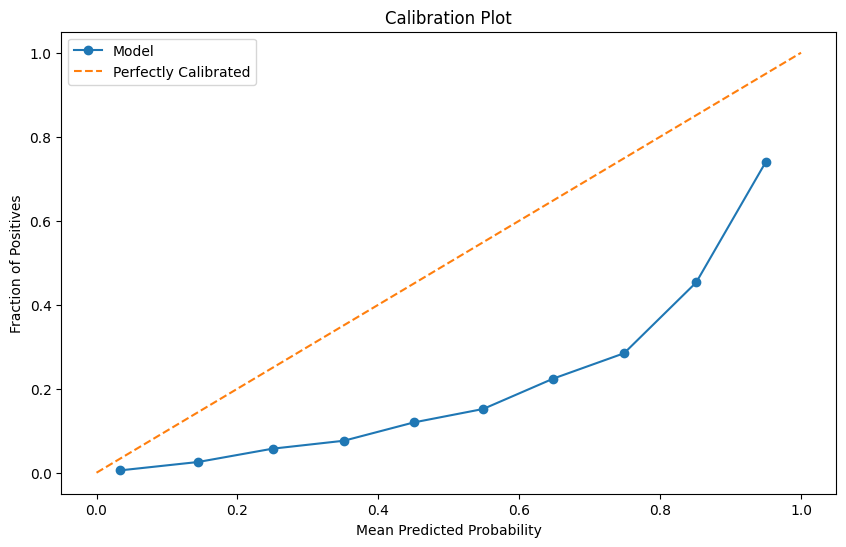

In [ ]:
plot_calibration_curve(y_test, y_test_pred_prob, n_bins=10)

##### Threshold Adjustment

Best Threshold: 0.76
Metrics at Best Threshold for Balanced F1 Score:
Accuracy: 0.9057
Balanced Accuracy: 0.7565
Precision: 0.5582
Recall: 0.5668
F1 Score: 0.5624
MCC: 0.5096


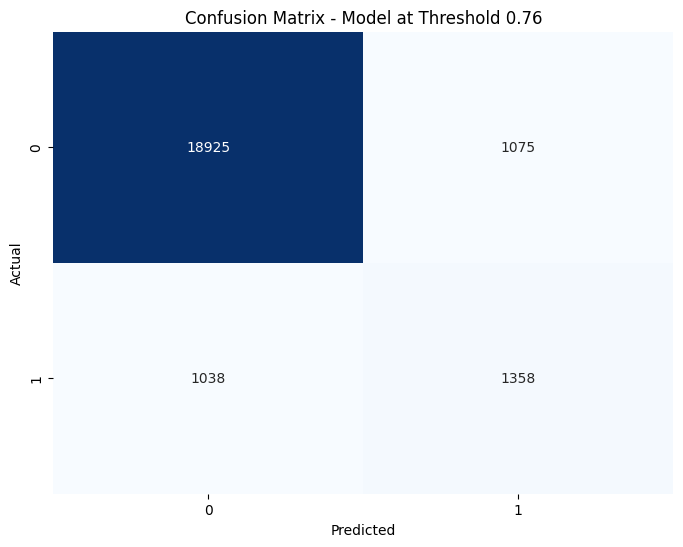

In [ ]:
# Generate predictions for the test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_val = y_val.astype(int)

thresholds = np.arange(0.1, 0.6, 0.01)
best_threshold, best_metrics = find_balanced_threshold(y_val, y_val_pred_prob, thresholds)

print(f"Best Threshold: {best_threshold}")
print("Metrics at Best Threshold for Balanced F1 Score:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate predictions using the best threshold
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

# Compute confusion matrix
cm_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Plot confusion matrix for the adjusted threshold
plot_confusion_matrix(cm_adjusted, f'Model at Threshold {best_threshold:.2f}')

#### ~~Enhanced Binary Classification Model Using SMOTE and Edited Nearest Neighbors~~

In [ ]:
# Reshape the data to 2D
num_samples, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, num_timesteps * num_features)

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)

X_train_res, y_train_res = smote_enn.fit_resample(X_train_reshaped, y_train)

# Reshape data back to 3D
X_train_res = X_train_res.reshape(-1, num_timesteps, num_features)

X_train_res.shape

In [ ]:
model_name = 'SMOTE_ENN_Deep_LSTM_Classifier'

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[precision_m, recall_m, 'accuracy', f1_m])

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_checkpoint.h5")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train_res, y_train_res, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Save the final model
model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, f"{model_name}_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, f"{model_name}_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)

In [ ]:
exaluate_model(model, X_test, y_test)

Model exhibits signs of overfitting, which may be due to the complex nature of combining both oversampling and undersampling techniques.

In [ ]:
# Plot training history
plot_and_save_training_history(history, model_name, save_dir='images')

In [ ]:
# Generate predictions for the test set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Ensure y_test is also of type int
y_test = y_test.astype(int)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

##### Model Calibration

##### Threshold Adjustment

#### Comparison of Data Balancing Approaches

All models have the following parameters:
- Number of Layers: 2
- Number of Units: 64
- Dropout Percentage: 0.3
- Regularization Factor (Dense Layer): 0.01

Below are the results of various models trained with different strategies:

| Model                                                | Probability Threshold | Accuracy | Balanced Accuracy | Precision | Recall | F1 Score | MCC   |
|------------------------------------------------------|-----------------------|----------|-------------------|-----------|--------|----------|-------|
| Deep LSTM Model with Threshold Adjustment            | 0.26                  | 0.9025   | 0.7757            | 0.5390    | 0.6144 | 0.5742   | 0.5209|
| Weighted Deep LSTM Model                             | 0.5                   | 0.9170   | 0.6764            | 0.7171    | 0.3702 | 0.4883   | 0.4772|
| Weighted Deep LSTM Model with Threshold Adjustment   | 0.3                   | 0.9102   | 0.7519            | 0.5854    | 0.5505 | 0.5674   | 0.5177|
| Recall Based Weight Optimized Model                  | 0.5                   | 0.7988   | 0.8069            | 0.3249    | 0.8172 | 0.4650   | 0.4278|
| Recall Based Weight Optimized Model with Threshold Adjustment | 0.75         | 0.8936   | 0.7623            | 0.5023    | 0.5952 | 0.5448   | 0.4873|
| MCC Based Weight Optimized Model                     | 0.5                   | 0.8759   | 0.7795            | 0.4456    | 0.6569 | 0.5310   | 0.4741|
| MCC Based Weight Optimized Model with Threshold Adjustment | 0.59              | 0.8961   | 0.7589            | 0.5128    | 0.5843 | 0.5462   | 0.4892|
| Oversampled Deep LSTM Model                          | 0.5                   | 0.9157   | 0.6818            | 0.6899    | 0.3844 | 0.4937   | 0.4748|
| Oversampled Deep LSTM Model with Threshold Adjustment | 0.28                 | 0.9004   | 0.7624            | 0.5312    | 0.5868 | 0.5576   | 0.5024|
| Undersampled Deep LSTM Model                         | 0.5                   | 0.8283   | 0.8221            | 0.3645    | 0.8143 | 0.5036   | 0.4669|
| Undersampled Deep LSTM Model with Threshold Adjustment | 0.76                | 0.9057   | 0.7565            | 0.5582    | 0.5668 | 0.5624   | 0.5096|


Given our business case of predicting which customers will buy the targeted product, with class 1 being the minority class (buyers), our goal is to minimize loss of class 1 candidates (high recall) while maintaining a balanced F1 score. Thus, we focused on models that provide high recall along with good F1 and MCC scores to ensure overall good performance.

Minimize the loss of class 1 candidates (high recall).
Maintain a balanced F1 score or MCC  Here is a comparison considering these criteria:Recall Optimized Weighted Deep LSTM Model shows the highest recall (0.8172), but it has lower precision (0.3249) and F1 score (0.4650).
Threshold Adjusted Recall Optimized Weighted Deep LSTM Model with a threshold of 0.75 balances recall (0.5952) with better precision (0.5023) and F1 score (0.5448).
F1 Optimized Binary Classification Model with LSTM achieves good recall (0.6144) and the highest F1 score (0.5742), suggesting a strong balance between precision and recall.

 Although, the highest possible recall (0.8172) is achieved by the Recall Based Weight Optimized Model, this model performs poor in terms of F1 score (0.4650) and MCC (0.4278). On the other hand, Deep LSTM Model with Threshold Adjustment stands out with a good balance of recall (0.6144), F1 score (0.5742), and MCC (0.5209).  This model provides a good compromise between high recall and overall balanced performance, which aligns well with our business goals. By systematically tuning these hyperparameters, we hoped to further improve the performance of the chosen model.

## Hyperparameter Tuning with Cross-Validation

Since we want to minimize the loss of class 1 candidates (high recall) while maintaining a balanced F1 score or MCC, we decided to tune parameters while maximizing F1 score and then adjusting the threshold for optimum recall. With this approach  we ensures a balanced initial model and allows for fine-tuning to meet your recall requirements.

In [ ]:
# Define model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=[precision_m, recall_m, f1_m, mcc_m, 'accuracy'])
    return model

# Define custom class weights
def get_class_weights(hp):
    weight_0 = hp.Float('weight_0', min_value=0.5, max_value=1.0, step=0.1)
    weight_1 = hp.Float('weight_1', min_value=4.0, max_value=5.0, step=0.1)
    return {0: weight_0, 1: weight_1}

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective=Objective("val_f1_m", direction="max"),  # Explicitly specify the objective
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train with each hyperparameter set
    directory='tuner_dir',
    project_name='deep_lstm_hyperparameter_tuning'
)

# Perform 3-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
val_scores = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"Deep_LSTM_Model_fold_{fold_no}_checkpoint.h5")
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

    # Get class weights
    class_weights = get_class_weights(tuner.oracle.hyperparameters)

    # Run hyperparameter search
    tuner.search(X_train_fold, y_train_fold, epochs=50, validation_data=(X_val_fold, y_val_fold),
                 class_weight=class_weights, callbacks=[early_stopping, reduce_lr, model_checkpoint])

    # Evaluate the best model on the validation fold
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64,
                        validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    val_scores.append(model.evaluate(X_val_fold, y_val_fold, verbose=0))
    fold_no += 1

# Average validation scores across folds
avg_val_scores = np.mean(val_scores, axis=0)
print(f"Average validation scores across folds: {avg_val_scores}")

# Save the final model
model_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model.h5")
model.save(model_path)

# Save the training history
history_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model_history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Convert NumPy data types to native Python types
history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

history_json_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model_history.json")
with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)



Trial 10 Complete [00h 02m 51s]
val_f1_m: 0.4609864056110382

Best val_f1_m So Far: 0.4915175139904022
Total elapsed time: 00h 26m 55s
Epoch 1/50
700/700 [==============================] - 11s 10ms/step - loss: 0.4480 - precision_m: 0.2633 - recall_m: 0.7431 - f1_m: 0.3751 - mcc_m: 0.3251 - accuracy: 0.7431 - val_loss: 0.4371 - val_precision_m: 0.3162 - val_recall_m: 0.8251 - val_f1_m: 0.4477 - val_mcc_m: 0.4151 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 7s 10ms/step - loss: 0.3765 - precision_m: 0.3147 - recall_m: 0.8205 - f1_m: 0.4427 - mcc_m: 0.4124 - accuracy: 0.7884 - val_loss: 0.5066 - val_precision_m: 0.2733 - val_recall_m: 0.8867 - val_f1_m: 0.4103 - val_mcc_m: 0.3861 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 6s 9ms/step - loss: 0.3669 - precision_m: 0.3154 - recall_m: 0.8332 - f1_m: 0.4462 - mcc_m: 0.4182 - accuracy: 0.7891 - val_loss: 0.4029 - val_precision_m: 0.3279 - val_recall_m:

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 128)           225792    
                                                                 
 dropout_6 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 357505 (1.36 MB)
Trainable params: 357505 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
dict_keys(['loss',

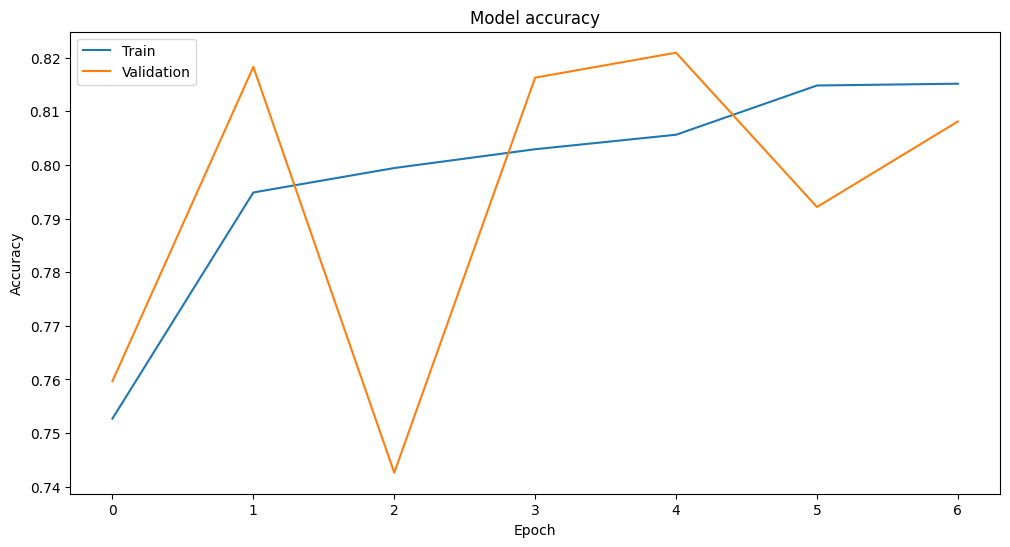

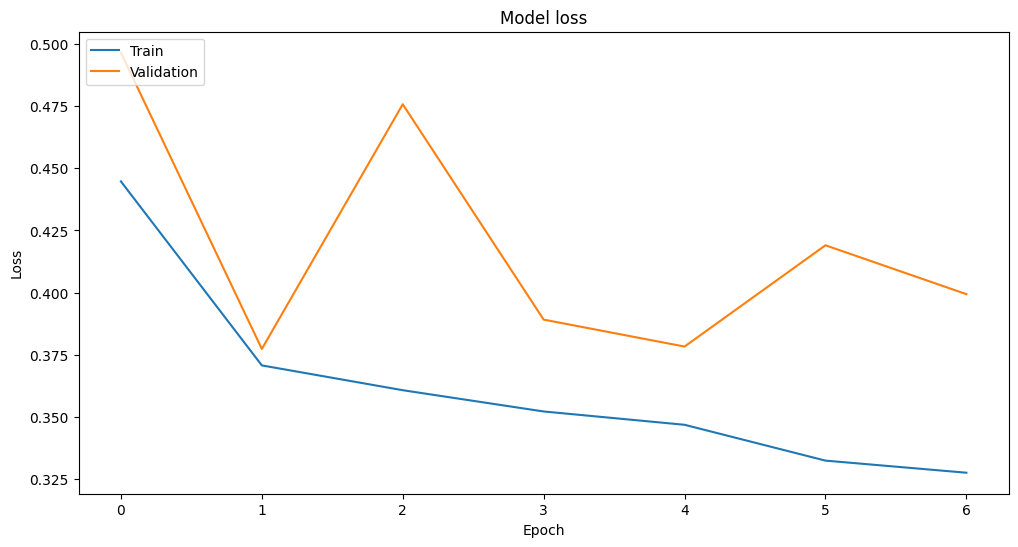

In [ ]:
# Load the best model
best_model_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model.h5")
best_model = tf.keras.models.load_model(best_model_path, custom_objects={
    'precision_m': precision_m,
    'recall_m': recall_m,
    'f1_m': f1_m,
    'mcc_m': mcc_m
})

# Print model summary to verify
best_model.summary()

# Load the training history
history_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model_history.pkl")
with open(history_path, 'rb') as file:
    history = pickle.load(file)

# If the history was saved as JSON, you can load it as follows
history_json_path = os.path.join(MODEL_DIR, "Deep_LSTM_Model_history.json")
with open(history_json_path, 'r') as f:
    history_dict = json.load(f)

# Print the training history keys to verify
print(history.keys())
# or if loaded from JSON
print(history_dict.keys())

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Function to find the best threshold for recall
def find_best_threshold(model, X_val, y_val):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_threshold = 0.5
    best_recall = 0
    for threshold in thresholds:
        y_pred_prob = model.predict(X_val)
        y_pred = (y_pred_prob >= threshold).astype(int)
        recall = recall_m(y_val, y_pred)
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    return best_threshold, best_recall

# Find the best threshold on validation set
best_threshold, best_recall = find_best_threshold(best_model, X_val, y_val)
print(f"Best threshold for recall: {best_threshold}, Best recall: {best_recall}")


700/700 [==============================] - 19s 27ms/step
Best threshold for recall: 0.0, Best recall: 0.9999999999582638


Setting threshold to 0 is a dumb idea, we decided to report the results of the best model. We maximized recall for our business case at the sake of precision. We had a well balanced accuracy at the end.

In [ ]:
evaluate_model(best_model, X_test, y_test)

700/700 [==============================] - 21s 29ms/step
Accuracy: 0.8208
Precision: 0.3470
Recall: 0.7659
F1 Score: 0.4776
MCC Score: 0.4317
Balanced Accuracy: 0.7966


(0.8207715663511341,
 0.3470121028744327,
 0.7658597662771286,
 0.4776158250910984,
 0.43173907136514567,
 0.7966048831385644)

## Future Work

Due to high imbalance in the dataset, the metrics could be improved up to a point but nothing more. In the future other algorithms such as CNN feature extraction and LSTM classification, or Auto-Encoder LSTM architecture, GNNs with graph embeddings will be explored.


+ Auto-encoder LSTM: This model treats the minority class as outliers for anomaly detection. By learning a compressed representation of the data, the auto-encoder LSTM can identify deviations that indicate rare events.
+ CNN + LSTM: A hybrid model combining Convolutional Neural Networks (CNN) and LSTM. CNNs are used to extract spatial features from the data, which are then fed into an LSTM to capture temporal dependencies.
+ Graph Embeddings: Utilizes graph-based representations to capture relationships between data points, enhancing the model’s ability to learn complex patterns.
+ Graph Neural Networks (GNN): GNNs are designed to perform inference on data described by graphs. They are particularly powerful for capturing dependencies and interactions in complex datasets.